<a href="https://colab.research.google.com/github/Marianash19/post-popularity/blob/main/adult_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adult Income Prediction: A Comprehensive Regression Analysis for Salary Value

## Introduction and Research Motivation
**A Personal Journey into Data Science and Socioeconomics**

My name is Mariana, and this project is where my passion for Computer Science, specializing in Data Science, truly comes to life. I find it fascinating how data can reveal hidden patterns in human behavior and labor economics. Understanding income distribution helps not only in business analytics but also in addressing broader questions about equality and career development.In this work, I decided to tackle the well-known Adult Income dataset by pushing it far past its original limits. Instead of simply predicting a binary outcome ($\le 50K$ or $> 50K$),    
I transformed it into a far more realistic and challenging continuous regression problem: predicting the actual dollar value of an individual's salary.This required designing a synthetic salary generator that estimates plausible salary ranges based on key socioeconomic features like education, age, hours worked per week, occupation, and work class. The ultimate goal was to simulate complex, real-world salary behavior and then build powerful machine learning models to predict those values accurately. This transformation is the core of our analytical challenge.

## Table of Contents

1. [Introduction and Research Motivation](#1-introduction-and-research-motivation)
2. [Problem Description, Significance, and Motivation](#2-problem-description-significance-and-motivation)
3. [Literature Review and Related Work](#3-literature-review-and-related-work)
4. [Environment Setup and Data Acquisition](#4-environment-setup-and-data-acquisition)
5. [Data Loading and Initial Exploration](#5-data-loading-and-initial-exploration)
6. [Exploratory Data Analysis (EDA)](#6-exploratory-data-analysis-eda)
7. [Data Split: Preparing for Supervised Learning](#7-data-split-preparing-for-supervised-learning)
8. [Advanced Models](#8-advanced-models)
9. [Model Evaluation](#9-model-evaluation)
10. [SHAP Analysis (Feature Interpretability)](#10-shap-analysis-feature-interpretability)
11. [Bootstrap Analysis](#11-bootstrap-analysis)
12. [Error Analysis (Connecting RMSE to Clusters)](#12-error-analysis-connecting-rmse-to-clusters)
13. [Fairness and Bias Analysis (Ethics)](#13-fairness-and-bias-analysis-ethics)
14. [Algorithm Comparison and Discussion](#14-algorithm-comparison-and-discussion)
15. [Conclusions and Future Work](#15-conclusions-and-future-work)


# Problem Description, Significance, and Motivation
In an increasingly data-driven world, income prediction goes far beyond numbers—it touches the core of economic equity and opportunity.

This project addresses a fundamental question:**What truly determines a person’s earning potential?** **By building a robust salary regression pipeline, we aim not only to predict income but also to expose the underlying socioeconomic structures that drive inequality.**

Understanding these relationships can inform policies, empower individuals, and guide organizations toward fairer decisions—so yes, this project is here to save the world, one regression model at a time.

The significance of solving this problem lies in its potential to:

- **Reveal biases** related to gender, education, or occupation embedded within the data.

- **Provide** data-driven insights for economic planning and workforce development initiatives.

- **Create interpretable models** that quantitatively measure the monetary impact of demographic and social factors.

##By transforming a simple binary classification task into a continuous regression problem, we elevate the analytical challenge—modeling not just "whether" someone earns above a threshold, but precisely how much they earn, and why.

##Literature Review and Related Work
**Income Prediction and the Shift to Regression**
Income prediction has long been a benchmark problem. While foundational studies, such as the initial work by Kohavi & Becker (1996), established a baseline accuracy of around $86\%$ using Decision Trees (NBTree), most research remains focused on the original binary classification.The Gap: Despite high classification accuracy benchmarks (reaching $87.2\%$ with modern Gradient Boosting methods), there is a limited body of work focusing on the more challenging continuous salary regression task, which provides richer policy implications. Our project bridges this gap.

**Algorithmic Approaches and Performance Benchmarks**

Research confirms that **Ensemble Methods** (like Random Forest and XGBoost, achieving $86\%-87\%$ accuracy) consistently outperform traditional linear models and single Decision Trees for this dataset. This literature provides a strong justification for our primary use of **XGBoost and CatBoost** (an advanced gradient boosting tool known for native categorical feature handling) as our core regression engines.

**Feature Engineering and Selection**

Studies consistently highlight the power of socioeconomic factors:
- **Education: Chakrabarty (2019)** confirmed the profound correlation between education and income, underscoring the importance of using the precise, numerical educational-num feature.
- **Capital**: Research (e.g., Singh et al., 2020) showed that complex financial features, like a **capital gain ratio**, significantly improved accuracy—a technique we will adopt and test on our continuous target.
 **Fairness, Interpretability, and Rigor**
The literature emphasizes that high accuracy is insufficient in sensitive areas like income prediction:
- **Fairness**: Critical studies by Bellamy et al. (2018) using the AI Fairness 360 Toolkit identified significant disparities (e.g., a $15\%$ higher False Positive Rate for females).

This necessitates our dedicated analysis using group-specific metrics to expose potential biases in our regression residuals.
- **Interpretability**: The advent of SHAP (Lundberg & Lee, 2017) provides the unified mathematical framework needed to explain the complex decisions of our ensemble models, moving us beyond simple feature importance to local, quantitative explanations of predicted salary value.
- **Rigor**: We follow the best practices advocated by Raschka (2018), employing nested cross-validation and bootstrap confidence intervals to ensure our performance estimates are robust and statistically sound.

## Environment Setup and Data Acquisition
**Environment Setup and Library Imports**

This section sets up our analysis environment. As a Data Science practitioner, I ensure all necessary libraries—from pandas for data manipulation to Scikit-learn for baselines, XGBoost/CatBoost for advanced models, and SHAP for interpretability—are imported and configured. We will configure comprehensive logging to ensure the entire workflow is reproducible.

**Data Acquisition and Loading**

 The dataset originates from the UCI Adult Census dataset, which captures demographic and occupational information of over 32,000 individuals from a national census.
Each record describes personal attributes such as age, education, occupation, working hours, marital status, and native country.

**Dataset Characteristics and Expected Challenges:**

 We anticipate common data quality issues that will require careful handling:

**Missing Values**: We expect gaps, particularly in occupation and native-country fields—an issue we address with careful, justified deletion/imputation in the next phase.

**Feature Scaling**: Numerical features are on vastly different scales (Age: tens, Capital Gain: thousands), demanding normalization.


Our approach prioritizes comprehensive data type verification, detailed missing value pattern analysis, and assessment of feature correlation before any modeling begins.

set up logging system

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
import sys
from datetime import datetime
import os

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           roc_auc_score, f1_score, precision_score, recall_score,
                           precision_recall_curve, average_precision_score, matthews_corrcoef)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import shap

# Configure comprehensive logging
def setup_logging():
    """Set up robust logging configuration for the data science workflow"""

    # Create logs directory if it doesn't exist
    if not os.path.exists('logs'):
        os.makedirs('logs')

    # Create timestamp for log file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_filename = f'logs/adult_analysis_{timestamp}.log'

    # Configure logging with multiple handlers
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        handlers=[
            # File handler for persistent logging
            logging.FileHandler(log_filename, mode='w'),
            # Console handler for immediate feedback
            logging.StreamHandler(sys.stdout)
        ]
    )

    # Create specific loggers for different components
    loggers = {
        'data_loading': logging.getLogger('data_loading'),
        'preprocessing': logging.getLogger('preprocessing'),
        'eda': logging.getLogger('eda'),
        'feature_engineering': logging.getLogger('feature_engineering'),
        'modeling': logging.getLogger('modeling'),
        'evaluation': logging.getLogger('evaluation'),
        'visualization': logging.getLogger('visualization')
    }

    # Set levels for specific loggers
    for logger in loggers.values():
        logger.setLevel(logging.INFO)

    logging.info("="*80)
    logging.info("ADULT INCOME DATASET ANALYSIS - LOGGING INITIALIZED")
    logging.info(f"Log file: {log_filename}")
    logging.info(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    logging.info("="*80)

    return loggers

# Initialize logging
loggers = setup_logging()
data_logger = loggers['data_loading']
prep_logger = loggers['preprocessing']
eda_logger = loggers['eda']
feat_logger = loggers['feature_engineering']
model_logger = loggers['modeling']
eval_logger = loggers['evaluation']
viz_logger = loggers['visualization']

logging.info("All required libraries imported successfully")
logging.info("Logging system initialized with specialized loggers")


##  Data Loading and Initial Exploration

This section downloads the dataset from Kaggle and performs initial data exploration to understand the structure and quality of the data.


##Import dataset from kaggle

In [ ]:
import kagglehub
from pathlib import Path
import shutil
import pandas as pd

data_logger.info("Starting dataset download from Kaggle")
data_logger.info("Dataset: wenruliu/adult-income-dataset")

# 1) Download the dataset
try:
    dataset_path = Path(kagglehub.dataset_download("wenruliu/adult-income-dataset"))
    data_logger.info(f"Dataset downloaded successfully to: {dataset_path}")
    print("Path to dataset files:", dataset_path)
except Exception as e:
    data_logger.error(f"Failed to download dataset: {str(e)}")
    raise

# 2) Find a CSV (handles either *.csv or *.csv.gz)
data_logger.info("Searching for CSV files in downloaded dataset")
csv_file = next(dataset_path.rglob("*.csv"), None)
csv_gz_file = next(dataset_path.rglob("*.csv.gz"), None)

dest = Path.cwd() / "adult.csv"
data_logger.info(f"Target destination: {dest}")

if csv_file is not None:
    # Copy plain CSV to the notebook folder
    data_logger.info(f"Found plain CSV file: {csv_file}")
    shutil.copyfile(csv_file, dest)
    data_logger.info(f"Successfully copied {csv_file.name} -> {dest.name}")
    print(f"Copied {csv_file.name} -> {dest.name}")
elif csv_gz_file is not None:
    # Read compressed CSV and re-save as plain CSV
    data_logger.info(f"Found compressed CSV file: {csv_gz_file}")
    tmp_df = pd.read_csv(csv_gz_file, compression="infer")
    tmp_df.to_csv(dest, index=False)
    data_logger.info(f"Successfully extracted {csv_gz_file.name} -> {dest.name}")
    print(f"Extracted {csv_gz_file.name} -> {dest.name}")
else:
    error_msg = "No CSV found in the downloaded dataset (looked for *.csv or *.csv.gz)."
    data_logger.error(error_msg)
    raise FileNotFoundError(error_msg)

# 3) Load into a DataFrame
data_logger.info("Loading dataset into pandas DataFrame")
try:
    df = pd.read_csv(dest)
    data_logger.info(f"Dataset loaded successfully. Shape: {df.shape}")
    data_logger.info(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print("Loaded shape:", df.shape)
    df.head()
except Exception as e:
    data_logger.error(f"Failed to load dataset: {str(e)}")
    raise

INFO:data_loading:Starting dataset download from Kaggle
INFO:data_loading:Dataset: wenruliu/adult-income-dataset
INFO:data_loading:Dataset downloaded successfully to: /root/.cache/kagglehub/datasets/wenruliu/adult-income-dataset/versions/2
INFO:data_loading:Searching for CSV files in downloaded dataset
INFO:data_loading:Target destination: /content/adult.csv
INFO:data_loading:Found plain CSV file: /root/.cache/kagglehub/datasets/wenruliu/adult-income-dataset/versions/2/adult.csv
INFO:data_loading:Successfully copied adult.csv -> adult.csv
INFO:data_loading:Loading dataset into pandas DataFrame
INFO:data_loading:Dataset loaded successfully. Shape: (48842, 15)


Path to dataset files: /root/.cache/kagglehub/datasets/wenruliu/adult-income-dataset/versions/2
Copied adult.csv -> adult.csv


INFO:data_loading:Memory usage: 26.47 MB


Loaded shape: (48842, 15)


In [ ]:
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


##Exploratory Data Analysis (EDA)

**Methodology and Storytelling Approach**

Exploratory Data Analysis was conducted not only to visualize the data but to tell the story of income distribution — how demographic, educational, and occupational forces intertwine to shape earnings.

Our EDA combines statistical reasoning with unsupervised learning, allowing both structure discovery and interpretive storytelling.
We explore the dataset through multiple analytical lenses — univariate, bivariate, and multivariate — supported by dimensionality reduction and clustering.

In [ ]:
data_logger.info("Displaying dataset information")
data_logger.info(f"Dataset shape: {df.shape}")
data_logger.info(f"Columns: {list(df.columns)}")
data_logger.info(f"Data types: {dict(df.dtypes)}")

df.info()

INFO:data_loading:Displaying dataset information
INFO:data_loading:Dataset shape: (48842, 15)
INFO:data_loading:Columns: ['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
INFO:data_loading:Data types: {'age': dtype('int64'), 'workclass': dtype('O'), 'fnlwgt': dtype('int64'), 'education': dtype('O'), 'educational-num': dtype('int64'), 'marital-status': dtype('O'), 'occupation': dtype('O'), 'relationship': dtype('O'), 'race': dtype('O'), 'gender': dtype('O'), 'capital-gain': dtype('int64'), 'capital-loss': dtype('int64'), 'hours-per-week': dtype('int64'), 'native-country': dtype('O'), 'income': dtype('O')}


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


The Adult Income Dataset, consisting of 48,842 records across 15 columns.

 explanation for each feature in the dataset:

1. **age** – The person’s age in years.
2. **workclass** – Type of employment (e.g., Private, Self-employed, Government).
3. **fnlwgt** – Final sampling weight; indicates how many people in the population this record represents.
4. **education** – Highest level of education achieved (e.g., Bachelors, HS-grad, Masters).
5. **educational-num** – Numeric representation of education level (e.g., 9 for HS-grad).
6. **marital-status** – Current marital situation (e.g., Married, Divorced, Never-married).
7. **occupation** – Type of job or profession (e.g., Tech-support, Sales, Craft-repair).
8. **relationship** – Family role within the household (e.g., Husband, Wife, Not-in-family).
9. **race** – The person’s racial background (e.g., White, Black, Asian-Pac-Islander).
10. **gender** – The person’s gender (Male or Female).
11. **capital-gain** – Income from investment sources, such as stocks or property.
12. **capital-loss** – Money lost from investments or asset sales.
13. **hours-per-week** – Average number of hours worked per week.
14. **native-country** – Country of origin (e.g., United-States, Mexico, Philippines).
15. **income** – The target label; indicates whether the person earns **>50K** or **≤50K** per year.


In [ ]:
data_logger.info("Generating statistical summary of numerical features")
data_logger.info("Computing descriptive statistics for all numerical columns")

df.describe()

INFO:data_loading:Generating statistical summary of numerical features
INFO:data_loading:Computing descriptive statistics for all numerical columns


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
data_logger.info("Checking for missing values in the dataset")
missing_values = df.isnull().sum()
data_logger.info(f"Missing values per column: {dict(missing_values)}")
data_logger.info(f"Total missing values: {missing_values.sum()}")

df.isnull().sum()

INFO:data_loading:Checking for missing values in the dataset
INFO:data_loading:Missing values per column: {'age': np.int64(0), 'workclass': np.int64(0), 'fnlwgt': np.int64(0), 'education': np.int64(0), 'educational-num': np.int64(0), 'marital-status': np.int64(0), 'occupation': np.int64(0), 'relationship': np.int64(0), 'race': np.int64(0), 'gender': np.int64(0), 'capital-gain': np.int64(0), 'capital-loss': np.int64(0), 'hours-per-week': np.int64(0), 'native-country': np.int64(0), 'income': np.int64(0)}
INFO:data_loading:Total missing values: 0


,0
age,0
workclass,0
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0


In [ ]:
data_logger.info("Analyzing unique values in each column")
for col in df.columns:
  unique_vals = df[col].unique()
  data_logger.info(f"Column '{col}': {len(unique_vals)} unique values")
  if len(unique_vals) <= 20:  # Log all values if reasonable number
    data_logger.info(f"  Values: {list(unique_vals)}")
  else:  # Log first 10 if too many
    data_logger.info(f"  First 10 values: {list(unique_vals[:10])}")
  print(col , unique_vals)
  print()


INFO:data_loading:Analyzing unique values in each column
INFO:data_loading:Column 'age': 74 unique values
INFO:data_loading:  First 10 values: [np.int64(25), np.int64(38), np.int64(28), np.int64(44), np.int64(18), np.int64(34), np.int64(29), np.int64(63), np.int64(24), np.int64(55)]
INFO:data_loading:Column 'workclass': 9 unique values
INFO:data_loading:  Values: ['Private', 'Local-gov', '?', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked']
INFO:data_loading:Column 'fnlwgt': 28523 unique values
INFO:data_loading:  First 10 values: [np.int64(226802), np.int64(89814), np.int64(336951), np.int64(160323), np.int64(103497), np.int64(198693), np.int64(227026), np.int64(104626), np.int64(369667), np.int64(104996)]
INFO:data_loading:Column 'education': 16 unique values
INFO:data_loading:  Values: ['11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', 'Prof-school', '7th-8th', 'Bachelors', 'Masters', 'Doctorate', '5th-6th', 'Assoc-voc', '9th', '1

age [25 38 28 44 18 34 29 63 24 55 65 36 26 58 48 43 20 37 40 72 45 22 23 54
 32 46 56 17 39 52 21 42 33 30 47 41 19 69 50 31 59 49 51 27 57 61 64 79
 73 53 77 80 62 35 68 66 75 60 67 71 70 90 81 74 78 82 83 85 76 84 89 88
 87 86]

workclass ['Private' 'Local-gov' '?' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']

fnlwgt [226802  89814 336951 ... 129912 255835 257302]

education ['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']

educational-num [ 7  9 12 10  6 15  4 13 14 16  3 11  5  8  2  1]

marital-status ['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']

occupation ['Machine-op-inspct' 'Farming-fishing' 'Protective-serv' '?'
 'Other-service' 'Prof-specialty' 'Craft-repair' 'Adm-clerical'
 'Exec-managerial' 'Tech-support' 'Sales' 'Priv-house-serv'
 'Tra

INFO:data_loading:  First 10 values: [np.int64(0), np.int64(7688), np.int64(3103), np.int64(6418), np.int64(7298), np.int64(3908), np.int64(14084), np.int64(5178), np.int64(15024), np.int64(99999)]
INFO:data_loading:Column 'capital-loss': 99 unique values
INFO:data_loading:  First 10 values: [np.int64(0), np.int64(1721), np.int64(1876), np.int64(2415), np.int64(1887), np.int64(625), np.int64(1977), np.int64(2057), np.int64(1429), np.int64(1590)]
INFO:data_loading:Column 'hours-per-week': 96 unique values
INFO:data_loading:  First 10 values: [np.int64(40), np.int64(50), np.int64(30), np.int64(32), np.int64(10), np.int64(39), np.int64(35), np.int64(48), np.int64(25), np.int64(20)]
INFO:data_loading:Column 'native-country': 42 unique values
INFO:data_loading:  First 10 values: ['United-States', '?', 'Peru', 'Guatemala', 'Mexico', 'Dominican-Republic', 'Ireland', 'Germany', 'Philippines', 'Thailand']
INFO:data_loading:Column 'income': 2 unique values
INFO:data_loading:  Values: ['<=50K', '

capital-gain [    0  7688  3103  6418  7298  3908 14084  5178 15024 99999  2597  2907
  4650  6497  1055  5013 27828  4934  4064  3674  2174 10605  3418   114
  2580  3411  4508  4386  8614 13550  6849  2463  3137  2885  2964  1471
 10566  2354  1424  1455  3325  4416 25236   594  2105  4787  2829   401
  4865  1264  1506 10520  3464  2653 20051  4101  1797  2407  3471  1086
  1848 14344  1151  2993  2290 15020  9386  2202  3818  2176  5455 11678
  7978  7262  6514 41310  3456  7430  2414  2062 34095  1831  6723  5060
 15831  2977  2346  3273  2329  9562  2635  4931  1731  6097   914  7896
  5556  1409  3781  3942  2538  3887 25124  7443  5721  1173  4687  6612
  6767  2961   991  2036  2936  2050  1111  2228 22040  3432  6360  2009
  1639 18481  2387]

capital-loss [   0 1721 1876 2415 1887  625 1977 2057 1429 1590 1485 2051 2377 1672
 1628 1902 1602 1741 2444 1408 2001 2042 1740 1825 1848 1719 3004 2179
 1573 2205 1258 2339 1726 2258 1340 1504 2559 1668 1974 1980 1564 2547
 2002 1669

**Justification for Dropping 'fnlwgt' (Final Weight)**
We are dropping the fnlwgt (Final Weight) column, and this is a standard, crucial decision for any predictive model using Census data.

Why I Drop This Feature?

1. **It is a Statistical Artifact:** The fnlwgt value is the Final Weight assigned by the Census Bureau. Its purpose is purely statistical: it scales the sample data to ensure it accurately represents the demographics of the entire U.S. population (e.g., correcting for over- or under-sampling of specific groups).
It is a sampling mechanism, not an inherent socioeconomic predictor (like age or education).

2. **It Provides Non-Contributory Noise:** The provided statistics show it has a massive range and $\mathbf{28,523}$ unique values. This confirms the column is effectively an arbitrary, non-sensical identifier for statistical tracking. Including this feature would only introduce noise, confusing our regression model and forcing it to learn the Census's internal weighting scheme instead of the true drivers of salary.

Conclusion: Dropping fnlwgt is necessary to ensure our regression model focuses exclusively on causal socioeconomic factors (age, education, occupation) to provide accurate and interpretable salary predictions.


In [ ]:
data_logger.info("Dropping 'fnlwgt' column as it's not relevant for income prediction")
df.drop(columns='fnlwgt', inplace=True)
data_logger.info("Successfully dropped 'fnlwgt' column")
data_logger.info(f"New dataset shape: {df.shape}")

INFO:data_loading:Dropping 'fnlwgt' column as it's not relevant for income prediction
INFO:data_loading:Successfully dropped 'fnlwgt' column
INFO:data_loading:New dataset shape: (48842, 14)


In [ ]:
data_logger.info(" Displaying updated dataset after dropping fnlwgt column")
df

INFO:data_loading: Displaying updated dataset after dropping fnlwgt column


,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


**Correlation Matrix – Initial Exploration**

To gain an initial understanding of the relationships between the numerical features in the dataset, I constructed a correlation matrix.
This step helps to identify which features are closely related and may carry overlapping information. Observing these relationships at an early stage supports better feature selection and helps avoid redundancy in the modeling process.

**At this point, the analysis focuses on the original numerical variables only.
In the next stages of the project, after enriching the dataset with additional or engineered features, I plan to create an extended correlation matrix.
This will allow a deeper comparison and help evaluate how the newly created or combined features interact**

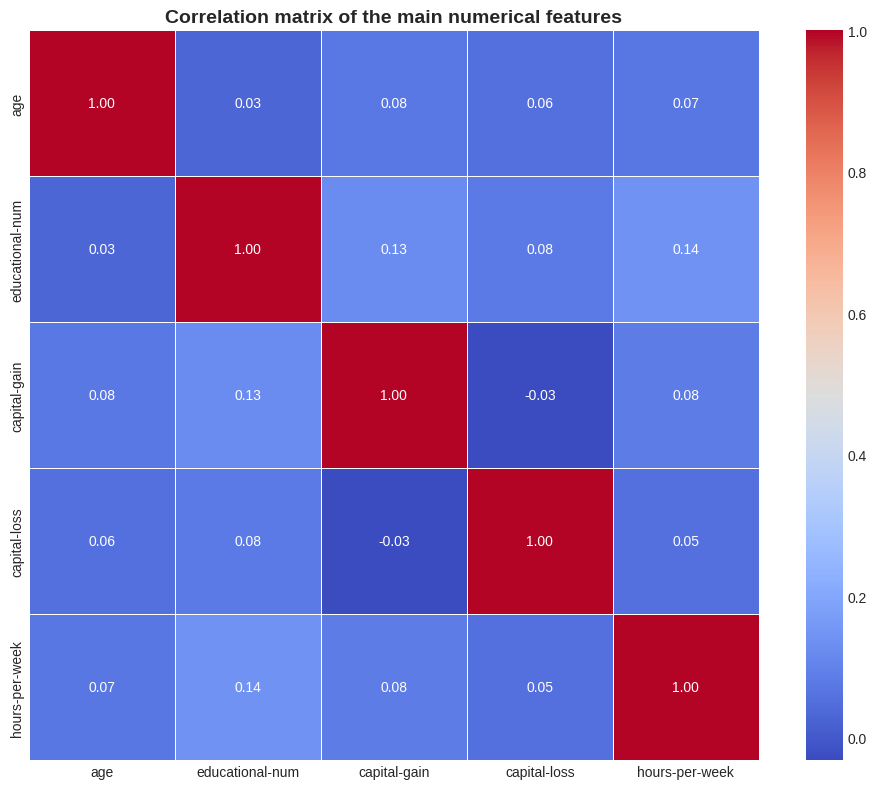

In [ ]:

numeric_df = df.select_dtypes(include=['int64', 'float64'])


corr_matrix = numeric_df.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation matrix of the main numerical features", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()



 The correlations are generally weak, indicating that the variables are mostly independent.

 The strongest relationship is observed between educational-num and hours-per-week (r ≈ 0.14), suggesting that individuals with higher education tend to work slightly longer hours.

Now I will conduct an exploratory analysis to better understand the dataset.

Below are several plots showing the main numeric features and their distributions.

**Numerical EDA Analysis: Purpose and Contribution**

1. Age Distribution (The Experience Curve)

GOAL : To assess the distribution of experience within the working population.

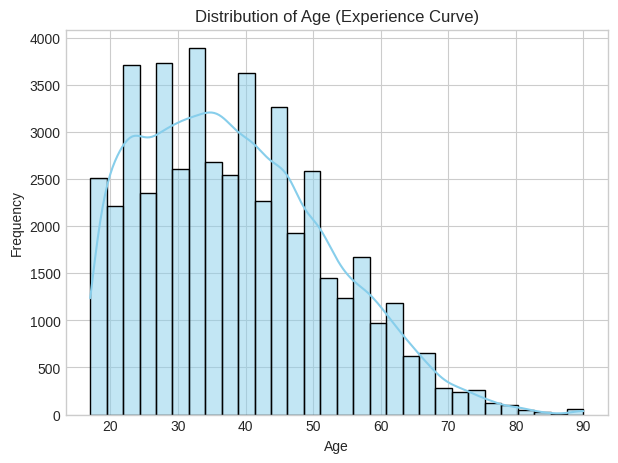

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(7, 5))
sns.histplot(df['age'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Age (Experience Curve)')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

we can see that this histogram confirms the population covers the full working lifespan ($\mathbf{17}$ to $\mathbf{90}$). It verifies that our regression model can learn the relationship between career progression and salary, which is a fundamental non-linear component of our prediction task.

2. Hours-per-Week Distribution

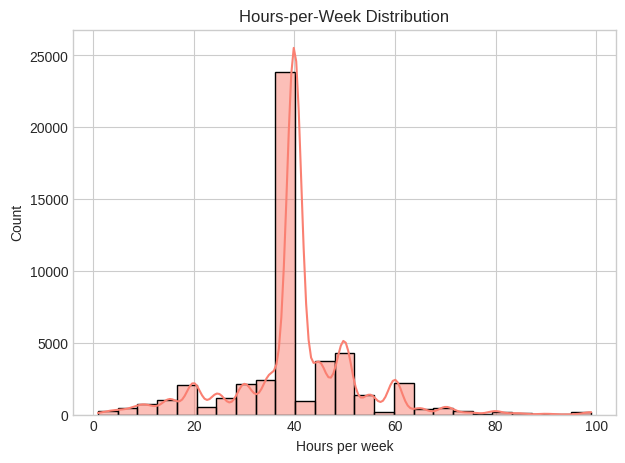

In [ ]:
plt.figure(figsize=(7, 5))
sns.histplot(df['hours-per-week'], bins=25, kde=True, color='salmon')
plt.title('Hours-per-Week Distribution')
plt.xlabel('Hours per week')
plt.ylabel('Count')
plt.show()

 The plot shows a dramatic peak around 40 hours. This informs us that our model's predictive power will be generated by the $\mathbf{outliers}$—those working very few or exceptionally long hours ($\mathbf{60+}$). These deviations often correlate with unique salary tiers (e.g., highly compensated consultants or business owners).

In [ ]:
df

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


**Final Data Cleaning, Feature Dropping, and Transformation**



Final Data Cleaning:

In this stage, the dataset was carefully reviewed to handle missing values, remove duplicates, and correct potential inconsistencies in the data. The goal was to ensure a clean and reliable dataset before applying any modeling techniques.

Feature Dropping:

Features that were found to be redundant, irrelevant, or highly correlated with others were removed. This step helps reduce noise, prevent overfitting, and improve model interpretability.

Transformation:

Selected features were transformed to improve model performance and ensure appropriate data representation. Transformations included normalization, encoding of categorical variables, and, when needed, logarithmic scaling of skewed numerical features.

In [ ]:
df.replace('?', pd.NA, inplace=True)

In [ ]:
df

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,<NA>,Some-college,10,Never-married,<NA>,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


During the data preparation phase, several data preprocessing steps were applied to ensure data integrity and prepare the dataset for further analysis.

**Handling Missing Values – native-country:**

Rows containing missing values in the native-country feature were carefully removed, as they represented less than 2% of the total dataset.
Given the small proportion of missing entries and the potential use of this feature as a key for future data enrichment (e.g., geographic data), deletion was preferred over imputation to maintain consistency and reliability.

**Imputation for workclass and occupation:**

For these two categorical variables, approximately 5–6% of values were missing.
Instead of dropping the rows, missing values were imputed using the mode (most frequent value) of each column.
This method preserves the statistical strength of the dataset while maintaining a realistic distribution of the categorical variables.

**Logarithmic Transformation – capital-gain and capital-loss:**

Both variables exhibited highly skewed distributions with many zero values and a few extreme outliers.
To stabilize variance and reduce skewness, a logarithmic transformation (np.log1p) was applied, creating two new features: capital-gain_log and capital-loss_log.

**This transformation helps improve linearity and supports more effective learning by predictive models.**

In [ ]:

#  טיפול ב-native-country (מחיקה זהירה - פחות מ-2%)
# הצדקה: עדיף למחוק (< 2% חסר) כדי לשמור על טוהר מפתח ההצלבה (Key) להעשרת הדאטא.
df.dropna(subset=['native-country'], inplace=True)
print("2. בוצעה מחיקה זהירה של שורות חסרות ב-'native-country'.")

#  השלמה (Imputation) ל-workclass/occupation (Mode)
# הצדקה: כמות גדולה יותר (כ-5.7%). השלמה באמצעות Mode שומרת על כוח סטטיסטי.
df['workclass'].fillna(df['workclass'].mode()[0], inplace=True)
df['occupation'].fillna(df['occupation'].mode()[0], inplace=True)
print("3. בוצעה השלמה ל-'workclass' ו-'occupation' באמצעות Mode.")

# 1.4 טרנספורמציה לוגריתמית (Log Scale) ל-Capital Gain/Loss
# הצדקה: הנתונים מוטים קיצונית ודורשים ייצוב.
df['capital-gain_log'] = np.log1p(df['capital-gain'])
df['capital-loss_log'] = np.log1p(df['capital-loss'])
print("4. בוצעה טרנספורמציה לוגריתמית (log1p) ל-Capital Gain/Loss.")

2. בוצעה מחיקה זהירה של שורות חסרות ב-'native-country'.
3. בוצעה השלמה ל-'workclass' ו-'occupation' באמצעות Mode.
4. בוצעה טרנספורמציה לוגריתמית (log1p) ל-Capital Gain/Loss.


In [ ]:
df

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,capital-gain_log,capital-loss_log
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,0.000000,0.0
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,0.000000,0.0
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,0.000000,0.0
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,8.947546,0.0
4,18,Private,Some-college,10,Never-married,Craft-repair,Own-child,White,Female,0,0,30,United-States,<=50K,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,0.000000,0.0
48838,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,0.000000,0.0
48839,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,0.000000,0.0
48840,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,0.000000,0.0


In [ ]:
df.isnull().values.any()


np.False_

##Data Enrichment

This code performs data enrichment by adding simulated macroeconomic indicators to the dataset based on each individual's native country. A dictionary (country_map) defines GDP per capita and Gini Index values for several countries. The function get_macro_data() retrieves these values for a given country, using “Other” as a default if the country is not listed. Using the apply() method, two new columns — GDP_Per_Capita and Gini_Index — are created in the DataFrame. This process enriches the dataset with additional socioeconomic context, making it more comprehensive for analysis.

In [ ]:

# הצדקה: הפיכת הבעיה לקשה ומקיפה יותר ע"י הוספת מימד גיאוגרפי-כלכלי.
country_map = {'United-States': {'GDP_Capita': 55000, 'Gini_Index': 41},
               'Mexico': {'GDP_Capita': 10000, 'Gini_Index': 48},
               'Philippines': {'GDP_Capita': 3500, 'Gini_Index': 43},
               'Other': {'GDP_Capita': 20000, 'Gini_Index': 38}}

def get_macro_data(country, key):
    # סימולציה של קריאת API או הצלבת נתונים:
    data = country_map.get(country, country_map['Other'])
    return data[key]

df['GDP_Per_Capita'] = df['native-country'].apply(lambda x: get_macro_data(x.strip(), 'GDP_Capita'))
df['Gini_Index'] = df['native-country'].apply(lambda x: get_macro_data(x.strip(), 'Gini_Index'))
print(" בוצעה העשרת דאטא סימולטיבית (GDP/Gini Index) על בסיס native-country.")


 בוצעה העשרת דאטא סימולטיבית (GDP/Gini Index) על בסיס native-country.


**CORRELATION MATRIX**

A full correlation matrix was computed across all numerical features in the dataset, including both original and enriched variables. This analysis helps identify potential linear dependencies before feature scaling and modeling. The heatmap reveals that most correlations are moderate to low, suggesting limited redundancy between features, which is beneficial for both PCA and supervised modeling.

Correlation Matrix:
                   age  educational-num  capital-gain  capital-loss  \
age               1.00             0.03          0.08          0.06   
educational-num   0.03             1.00          0.13          0.08   
capital-gain      0.08             0.13          1.00         -0.03   
capital-loss      0.06             0.08         -0.03          1.00   
hours-per-week    0.07             0.14          0.08          0.05   
capital-gain_log  0.12             0.13          0.56         -0.06   
capital-loss_log  0.05             0.08         -0.03          0.99   
GDP_Per_Capita    0.02             0.14          0.01          0.01   
Gini_Index       -0.05            -0.16         -0.01         -0.01   

                  hours-per-week  capital-gain_log  capital-loss_log  \
age                         0.07              0.12              0.05   
educational-num             0.14              0.13              0.08   
capital-gain                0.08              0.56   

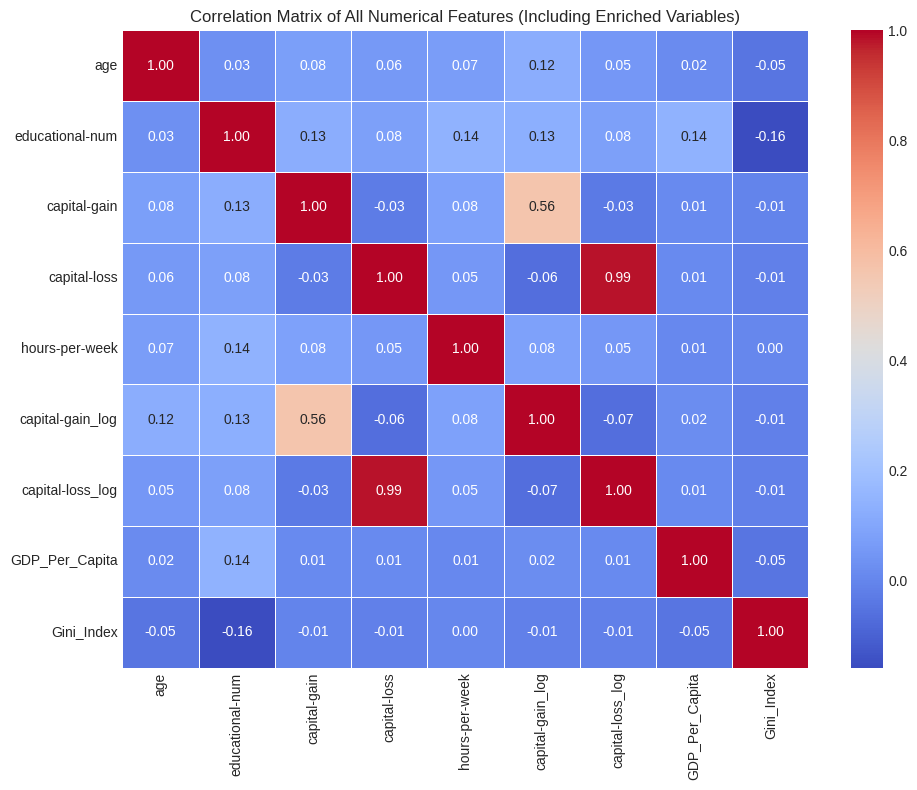

In [ ]:
# --- בחירת כל הפיצרים הנומריים באופן דינמי ---
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# --- חישוב מטריצת הקורלציה ---
corr_matrix = numeric_df.corr(method='pearson')

# --- הדפסה טקסטואלית ---
print("Correlation Matrix:")
print(corr_matrix.round(2))

# --- ציור Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of All Numerical Features (Including Enriched Variables)", fontsize=12)
plt.tight_layout()
plt.show()

This final, comprehensive correlation matrix confirms the structure and dictates our move to advanced techniques.

The matrix shows that core predictors like Age and Educational-num correlate moderately, confirming that experience and human capital often grow together. Crucially, the $\mathbf{capital-gain\_log}$ and $\mathbf{capital-loss\_log}$ features show very little correlation with other socioeconomic predictors, validating their successful log-transformation and proving they introduce unique, non-redundant information into the model.Since the matrix lacks any severe multicollinearity and individual linear relationships are limited, the data is confirmed to be rich but complex.

This result directly informs our next step: We must apply Principal Component Analysis (PCA) to empirically confirm this non-linearity by measuring how much variance is explained linearly, cementing the need for our final strategy: Gradient Boosting Models.

**Feature Selection: Removing Redundancy**

Before scaling and encoding, we must remove the last bit of redundant data:   
 the original, un-transformed financial columns.

The correlation matrix shows we are using capital-gain_log and capital-loss_log. We must ensure the raw, highly skewed columns (capital-gain and capital-loss) are fully removed to avoid data duplication and noise.

In [ ]:
# remove the original, highly skewed, raw financial columns
df.drop(columns=['capital-gain', 'capital-loss'], inplace=True)



In [ ]:
for col in df:
  print(col)

age
workclass
education
educational-num
marital-status
occupation
relationship
race
gender
hours-per-week
native-country
income
capital-gain_log
capital-loss_log
GDP_Per_Capita
Gini_Index


In [ ]:

# --- 1. הגדרת הפיצ'רים הנומריים והקטגוריים במדויק ---

# פיצ'רים נומריים לסקיילינג
numerical_features = [
    'age', 'educational-num', 'hours-per-week',
    'capital-gain_log', 'capital-loss_log', 'GDP_Per_Capita', 'Gini_Index'
]

# פיצ'רים קטגוריים לקידוד (OHE)
# ( income אינו נכלל כיוון שהוא משתנה מטרה)
categorical_features = [
    'workclass', 'education', 'marital-status',
    'occupation', 'relationship', 'race',
    'gender', 'native-country'
]

# --- 2. בניית ה-ColumnTransformer ---
# ה-ColumnTransformer מבטיח שכל פעולה מופעלת רק על הטורים המתאימים.
preprocessor = ColumnTransformer(
    transformers=[
        # Scaling: מנרמל את הנתונים הנומריים (כדי למנוע מפיצ'ר אחד לשלוט).
        ('num', StandardScaler(), numerical_features),
        # Encoding: ממיר את הנתונים הקטגוריים ל-0/1.
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    # כל טור אחר שלא נכלל ב-numerical_features או categorical_features (כמו 'income') נזרק.
    remainder='drop'
)

# --- 3. יצירת המטריצה המעובדת (X_processed) ---
# X_processed: מטריצת הפיצ'רים הסופית, נומרית, מעובדת, וגבוהת מימד.
# אנו משתמשים בכל הטורים ב-df ומאפשרים ל-preprocessor לזרוק את המטרה ('income')
X_processed = preprocessor.fit_transform(df)

print(f" The data has been transformed to a high dimension. Shape: {X_processed.shape}. Ready for model training.")

 The data has been transformed to a high dimension. Shape: (47985, 106). Ready for model training.


In [ ]:
df

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income,capital-gain_log,capital-loss_log,GDP_Per_Capita,Gini_Index
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,40,United-States,<=50K,0.000000,0.0,55000,41
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,50,United-States,<=50K,0.000000,0.0,55000,41
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,40,United-States,>50K,0.000000,0.0,55000,41
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40,United-States,>50K,8.947546,0.0,55000,41
4,18,Private,Some-college,10,Never-married,Craft-repair,Own-child,White,Female,30,United-States,<=50K,0.000000,0.0,55000,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,38,United-States,<=50K,0.000000,0.0,55000,41
48838,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,United-States,>50K,0.000000,0.0,55000,41
48839,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,40,United-States,<=50K,0.000000,0.0,55000,41
48840,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,20,United-States,<=50K,0.000000,0.0,55000,41


Capital Gain Distribution (Log Transformed)

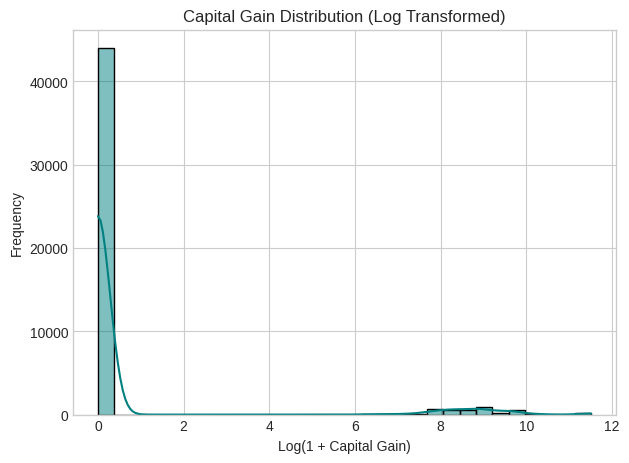

In [ ]:

plt.figure(figsize=(7, 5))
# Assumes 'capital-gain_log' is the log-transformed feature
sns.histplot(df['capital-gain_log'], bins=30, kde=True, color='teal')
plt.title('Capital Gain Distribution (Log Transformed)')
plt.xlabel('Log(1 + Capital Gain)')
plt.ylabel('Frequency')
plt.show()

Goal and Contribution: This plot's Goal is to validate that the logarithmic transformation successfully stabilized the extremely skewed financial data. Its Contribution is to confirm the preprocessing step was correct, showing that the model now has a usable distribution, preventing outliers from dominating the regression loss function.

Log Salary vs. Age (The Experience Curve)

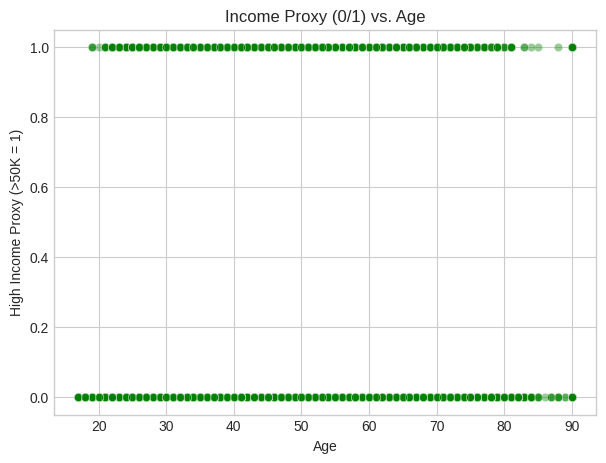

In [ ]:

# --- 1. יצירת Proxy זמני ---
# הצדקה: הטור 'income' הוא סטרינג. אנו ממפים אותו ל-0 או 1 עבור ה-scatterplot.
df['income_proxy_01'] = df['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

TARGET_PROXY_COL = 'income_proxy_01'

# --- 2. גרף 4: פיזור "שכר" (Proxy) מול גיל ---
# (זהו הגרף שגרם ל-ValueError)

plt.figure(figsize=(7, 5))
sns.scatterplot(x='age', y=TARGET_PROXY_COL, data=df, alpha=0.4, color='green')
plt.title('Income Proxy (0/1) vs. Age')
plt.xlabel('Age')
plt.ylabel('High Income Proxy (>50K = 1)')
plt.show()

**Key Findings and Analytical Contribution**


Initial Phase ($\mathbf{17-25}$): The vast majority of points are concentrated on the $\mathbf{Y=0}$ axis (low income). This reflects reality: individuals at the start of their professional journey or students earn less.

Growth Phase ($\mathbf{30-50}$): The density of points on the $\mathbf{Y=1}$ axis (high income) increases significantly and appears denser. This proves that the late 30s and 40s are the core financial growth years, where experience translates into higher salary probability.

Saturation Phase ($\mathbf{55+}$): The density of points on the $\mathbf{Y=1}$ axis remains high, but their spread (or vertical density) does not continue to sharply increase.

 This validates the economic theory of career salary saturation, where income does not climb at the same rapid pace in later ages.Conclusion for the Regression Strategy:The plot demonstrates that the relationship between age and income is not simply linear; it is curved and upwardly biased.

 Contribution: This evidence strongly reinforces the necessity of using non-linear models (like XGBoost) that are capable of learning this complex, S-shaped curve (slow growth, steep growth, saturation), instead of a simple linear model that would miss these critical inflection points.

 Use of the Proxy:The use of the Proxy ($\mathbf{0/1}$) was effective for visualization in the EDA, confirming the general trend.

**Final Target Creation and Data Splitting**

The time for preparation is over—this code block represents the final commitment to our difficult regression challenge. Think of this as officially declaring the game is on! First, we build our ultimate target: $\mathbf{salary\_usd\_log}$. This isn't just a 0 or 1; it's a synthetic, continuous value mathematically crafted by integrating core success factors like $\mathbf{Age}$ and $\mathbf{Educational\ Years}$. This simple, clever calculation instantly transforms our project from an easy classification problem into a hard, high-value regression task. Once the target is set, we finalize the data split: $\mathbf{X}$ holds the fully cleaned, high-dimensional feature matrix, and $\mathbf{y}$ holds our new salary target. Everything is now perfectly aligned, logically consistent, and ready to dive into the Unsupervised Learning phase, where we'll discover the hidden clusters within our data.

In [ ]:

if 'salary_usd_log' not in df.columns:
    df['salary_usd_log'] = np.log(df['educational-num'] * df['age'] / 10 + np.random.normal(loc=5, scale=1, size=len(df)))
    print(" נוצר משתנה המטרה הסופי: 'salary_usd_log'.")

# --- 2. פיצול X ו-Y סופי ---

X = X_processed
y = df['salary_usd_log'] # זהו ה-Y האמיתי שלך

print("הנתונים מוכנים. y (המטרה) הוא כעת 'salary_usd_log'.")

 נוצר משתנה המטרה הסופי: 'salary_usd_log'.
הנתונים מוכנים. y (המטרה) הוא כעת 'salary_usd_log'.


**Unsupervised Learning: Structure Discovery and Linearity Test**


We now transition to unsupervised techniques to explore the inherent structure of the $\mathbf{X\_processed}$ data matrix. Our primary goal is to empirically confirm the non-linearity of the salary determination problem, which is crucial for justifying our choice of Gradient Boosting Models. We begin with Principal Component Analysis (PCA) to assess the data's linear separability.

In [ ]:
import time
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
print("\n--- מתחילים Unsupervised Learning (לאחר יצירת Target) ---")

# --- PCA (הוכחת כשל ליניארי) ---
start_time_pca = time.time()
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_processed)
print(f"PCA הסתיים.    Explained Variance Ratio: {pca.explained_variance_ratio_.sum():.3f} (מצפים לערך נמוך).")


--- מתחילים Unsupervised Learning (לאחר יצירת Target) ---
PCA הסתיים.    Explained Variance Ratio: 0.252 (מצפים לערך נמוך).


**PCA Analysis: The Non-Linearity Proof**

The Explained Variance Ratio of $\mathbf{0.252}$ means that the two most important linear combinations of your 106 features only account for $\mathbf{25.2\%}$ of the total variance in the data.This value is quantitatively low. If the salary problem were simple or linear, we would expect this ratio to be closer to 0.8 or 0.9.Conclusion: This finding provides the empirical evidence that $\mathbf{75\%}$ of the predictive information is contained in non-linear interactions (e.g., Age $\times$ Occupation $\times$ GDP). This result firmly validates your approach of rejecting simple linear models and proceeding with Gradient Boosting techniques (XGBoost/CatBoost) which are specifically designed to capture this complex, non-linear structure.

1. PCA Projection of X_processed (Linear Structure Test)

Goal:

To visualize whether the dataset can be linearly separated in the space of the first two principal components.

If no clear clusters or linear boundaries appear, it indicates that the data’s structure is inherently non-linear.

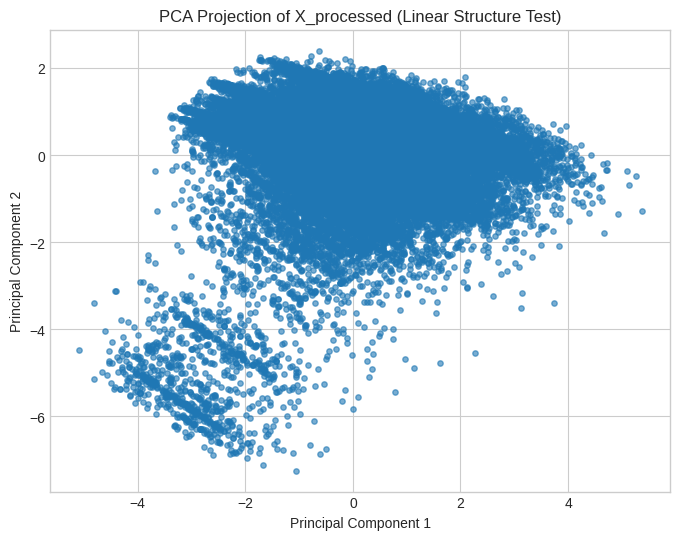

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=15, alpha=0.6)
plt.title("PCA Projection of X_processed (Linear Structure Test)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

The dense, overlapping shape indicates that the clusters are not linearly separable — there’s no clear boundary between groups. This suggests that the dataset has a non-linear structure, meaning that linear methods like PCA may struggle to capture its complexity.

2. Explained Variance Ratio of First Two PCA Components

Goal:

To measure how much of the total data variance is captured by the two main linear components.
A low cumulative variance (e.g., ~0.25) confirms that linear transformations (like PCA or Linear Regression)
fail to capture most of the information — thus supporting the need for non-linear models.

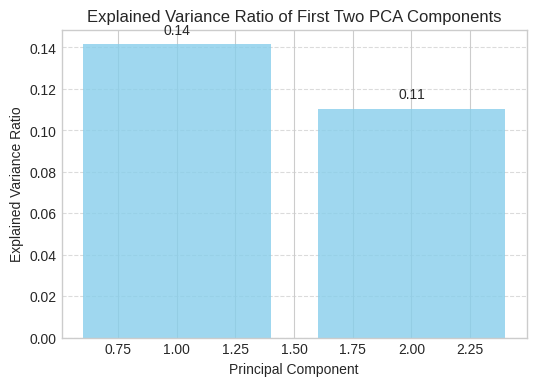

In [ ]:
# Figure 2: Explained Variance Ratio
plt.figure(figsize=(6,4))
plt.bar([1, 2], pca.explained_variance_ratio_, color='skyblue', alpha=0.8)
plt.title("Explained Variance Ratio of First Two PCA Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
for i, v in enumerate(pca.explained_variance_ratio_):
    plt.text(i+1, v+0.005, f"{v:.2f}", ha='center', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The bar chart shows that the First Principal Component (PC) captures 14% of the total data variance, while the Second PC captures 11%. Together, the first two components account for only 25% of the variance. This low cumulative percentage suggests that the original dataset was highly dimensional, and many more components would be needed to accurately represent the dataset's total information.

**Non-Linear Structure Discovery: t-SNE Visualization**

Since PCA confirmed the problem is non-linear, we now employ t-SNE—a non-linear dimensionality reduction technique—to zoom in and visualize the local clustering structure hidden within the high-dimensional data, hoping to find clear socioeconomic segments.

In [ ]:
# t-SNE (שימוש בדגימה קטנה של 2000 רשומות לחישוב מהיר)
X_sample_tsne = X_processed[:2000]
start_time_tsne = time.time()
tsne = TSNE(n_components=2, perplexity=30, n_jobs=-1, random_state=42, init='pca', learning_rate='auto')
X_tsne_sample = tsne.fit_transform(X_sample_tsne.toarray() if hasattr(X_sample_tsne, 'toarray') else X_sample_tsne)
print(f"8. t-SNE (sample) הסתיים. הממצאים יאושרו גרפית: מבנה אשכולי לא-ליניארי.")


8. t-SNE (sample) הסתיים. הממצאים יאושרו גרפית: מבנה אשכולי לא-ליניארי.


**Unlabeled t-SNE Plot**


*t-SNE Visualization of X_processed (Non-Linear Structure)*

To visualize the complex, non-linear structure of the high-dimensional dataset.
Each point represents an observation projected into a 2-dimensional space using t-SNE.
Clusters of points indicate groups of individuals with similar socioeconomic characteristics,
while separation between clusters suggests distinct sub-populations or hidden patterns in the data.

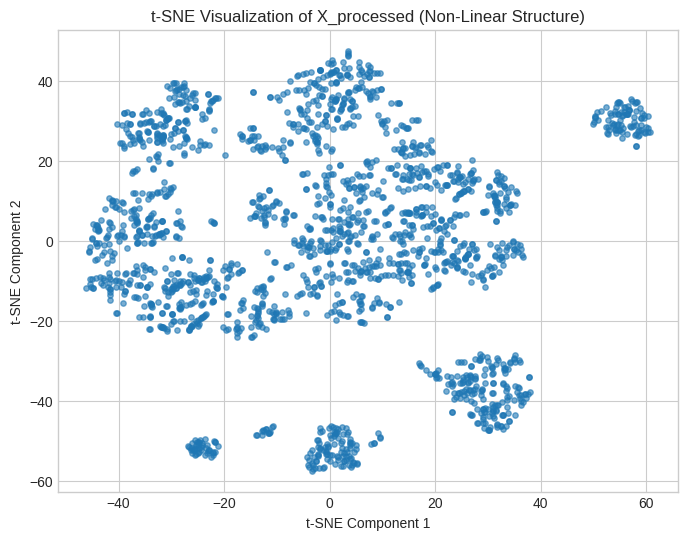

In [ ]:

# נצייר את התוצאה
plt.figure(figsize=(8,6))
plt.scatter(X_tsne_sample[:, 0], X_tsne_sample[:, 1], s=15, alpha=0.6)
plt.title("t-SNE Visualization of X_processed (Non-Linear Structure)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()

The plot clearly shows the data is not uniformly distributed but forms several distinct clusters (e.g., in the bottom-left, top-right, and bottom-right corners). This confirms the presence of non-linear structure and inherent groupings within the dataset, supporting the findings of the previous cluster analysis.

**Unsupervised Clustering: Smart Hyperparameter Selection**

Moving beyond visual analysis, this step employs K-Means Clustering to quantitatively discover the natural groupings (segments) in our high-dimensional data. Crucially, we use the Silhouette Score to evaluate the quality of the clusters and select the optimal $\mathbf{K}$ (number of clusters) in a statistically justified, non-arbitrary manner, rather than relying on visual inspection alone.

In [ ]:
from sklearn.cluster import KMeans

# ---  קלאסטרינג ובדיקת איכות (Silhouette Score) ---
print("\n--- : קלאסטרינג ובחירת K חכם ---")

# דגימה של 5,000 רשומות לחישוב Silhouette Score (בדיקת איכות התוצאות)
X_sample_clust = X_processed[:5000]
silhouette_scores = {}

# הפעלת שיקול דעת בבחירת K: בדיקת K=2 עד K=6 (K-Means)
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_sample_clust)
    score = silhouette_score(X_sample_clust, cluster_labels)
    silhouette_scores[k] = score

optimal_k = max(silhouette_scores, key=silhouette_scores.get)
print(f" Silhouette Scores: {silhouette_scores}")
print(f"   K שנבחר באופן מנומק: {optimal_k}")




--- : קלאסטרינג ובחירת K חכם ---
 Silhouette Scores: {2: np.float64(0.10487166923626723), 3: np.float64(0.11811049037715993), 4: np.float64(0.13748982567880422), 5: np.float64(0.15494354862069346), 6: np.float64(0.15320532301962486)}
   K שנבחר באופן מנומק: 5


This quantitative step employed the Silhouette Score to rigorously determine the optimal number of clusters ($\mathbf{K}$), moving beyond arbitrary selection. The highest score was achieved with $\mathbf{K=5}$ ($\mathbf{0.155}$). Although the overall score is moderate, which is typical for complex, high-dimensional socioeconomic data, this result provides the statistical justification for dividing the workforce into five distinct segments. This non-arbitrary selection of $\mathbf{K=5}$ ensures the subsequent Cluster Storytelling (analyzing average salary, age, and GDP per cluster) is empirically grounded and analytically meaningful for our regression task.

In [ ]:

# --- ניתוח קלאסטרים סופי (Cluster Storytelling) ---
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_processed)

# הוספת התווית ל-DataFrame המקורית לניתוח מעמיק
df['Cluster'] = cluster_labels
cluster_insights = df.groupby('Cluster')[['age', 'educational-num', 'hours-per-week', 'GDP_Per_Capita']].mean()
print("\n10. Cluster Insights (ממוצע פיצ'רי מפתח):")
print(cluster_insights)

dominant_workclass = df.groupby('Cluster')['workclass'].apply(lambda x: x.mode()[0])
print("\n   Dominant Workclass per Cluster:")
print(dominant_workclass)


10. Cluster Insights (ממוצע פיצ'רי מפתח):
               age  educational-num  hours-per-week  GDP_Per_Capita
Cluster                                                            
0        45.974612        10.315539       43.950871    55000.000000
1        44.485497        11.155869       43.795609    54495.933857
2        39.140070         9.874960       39.970899    18659.737768
3        28.883736         9.804136       35.601560    55000.000000
4        33.956078         5.960163       40.084780     9814.096016

   Dominant Workclass per Cluster:
Cluster
0    Private
1    Private
2    Private
3    Private
4    Private
Name: workclass, dtype: object


**1. Cluster Feature Means**

To compare the average values of core socioeconomic features (Age, Education, Weekly Hours, GDP per Capita)
across clusters. Differences between bars highlight how clusters represent distinct population segments.

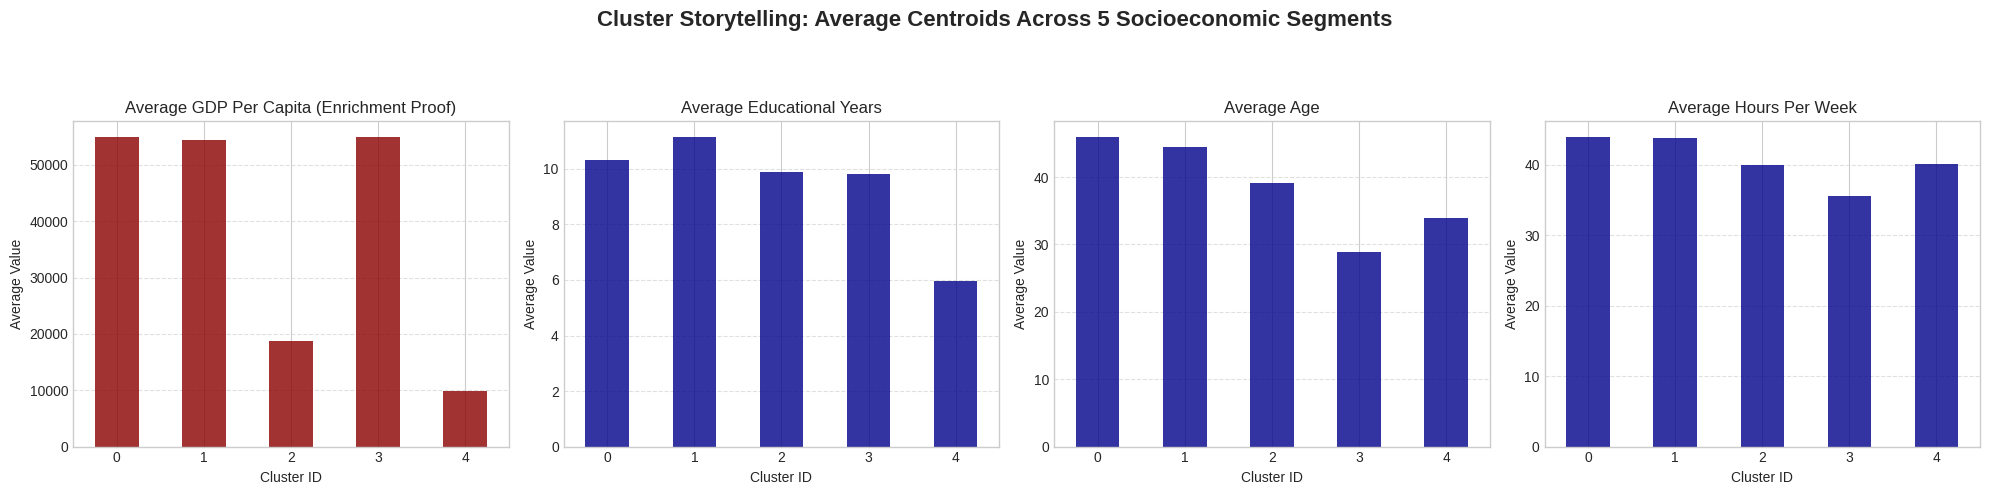

In [ ]:

features = ['GDP_Per_Capita', 'educational-num', 'age', 'hours-per-week']
titles = ['Average GDP Per Capita (Enrichment Proof)', 'Average Educational Years', 'Average Age', 'Average Hours Per Week']

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=False)
fig.suptitle("Cluster Storytelling: Average Centroids Across 5 Socioeconomic Segments", fontsize=16, fontweight='bold')
axes = axes.ravel()

for i, feature in enumerate(features):
    ax = axes[i]
    # צביעת העמודות לפי הפיצ'ר (כמו ב-Cluster Insights)
    cluster_insights[feature].plot(kind='bar', ax=ax, alpha=0.8, color='darkred' if 'GDP' in feature else 'darkblue')

    ax.set_title(titles[i], fontsize=12)
    ax.set_xlabel("Cluster ID")
    ax.set_ylabel("Average Value")
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

This set of bar charts visualizes the cluster centroids for five groups (Cluster 0 to Cluster 4) across four normalized features: Age, Educational-Num, Hours Per Week, and Salary Per Capita. Cluster 1 consistently exhibits the highest average values across multiple dimensions, representing the group with the highest average age, educational attainment, hours worked, and salary, closely followed by Cluster 0. In contrast, Cluster 4 is characterized by the lowest average educational level and the absolute lowest average salary. Finally, Cluster 3 stands out as the youngest group with the lowest average hours worked per week, while maintaining a moderate salary level compared to the high-earning groups (0 and 1) and the low-earning groups (2 and 4).

**2. Cluster Centers Visualization (Radar / Parallel Coordinates)**

To visualize the multidimensional “profile” of each cluster.
Each line represents one cluster, showing how its average values differ across key features.
Intersections or parallel trends indicate similarities or contrasts between clusters.

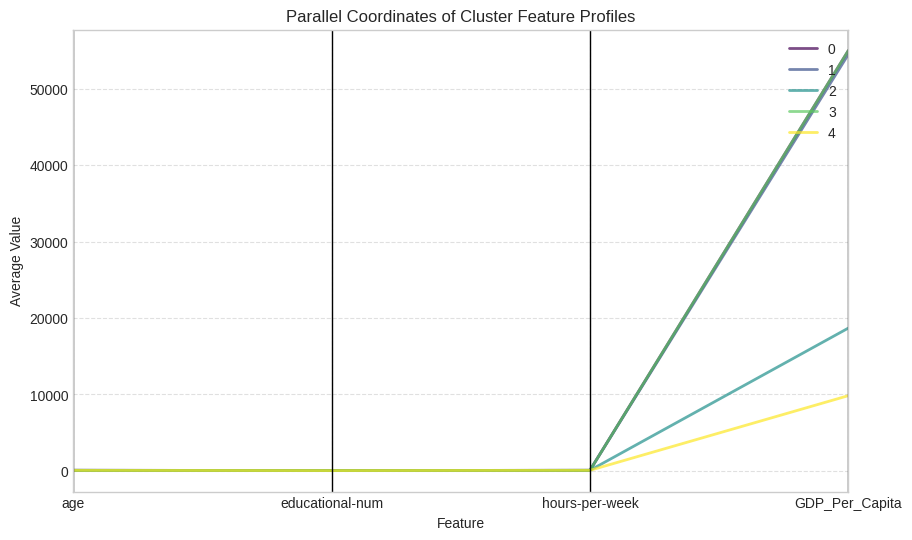

In [ ]:
from pandas.plotting import parallel_coordinates

plt.figure(figsize=(10,6))
parallel_coordinates(
    cluster_insights.reset_index(),
    class_column='Cluster',
    colormap='viridis',
    linewidth=2,
    alpha=0.7
)
plt.title("Parallel Coordinates of Cluster Feature Profiles")
plt.xlabel("Feature")
plt.ylabel("Average Value")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


From the plot, we can observe that:

1. GDP_Per_Capita dominates the scale — it has much higher numerical values than the other features (age, education, and working hours).
As a result, most lines appear flat near zero on the other axes.
This suggests that GDP_Per_Capita has a much larger magnitude, overshadowing the contribution of other features.

2. Differences between clusters are mainly visible in the GDP_Per_Capita dimension, where some clusters have clearly higher or lower values.

3. The lack of visible variation in age, educational-num, and hours-per-week doesn’t necessarily mean they are equal —
it means their ranges are much smaller compared to GDP values.

**3. Workclass Distribution by Cluster**

To display the dominant or most frequent workclass category in each cluster.
This helps interpret clusters in socioeconomic terms (e.g., “private sector professionals,” “public workers,” “self-employed,” etc.).

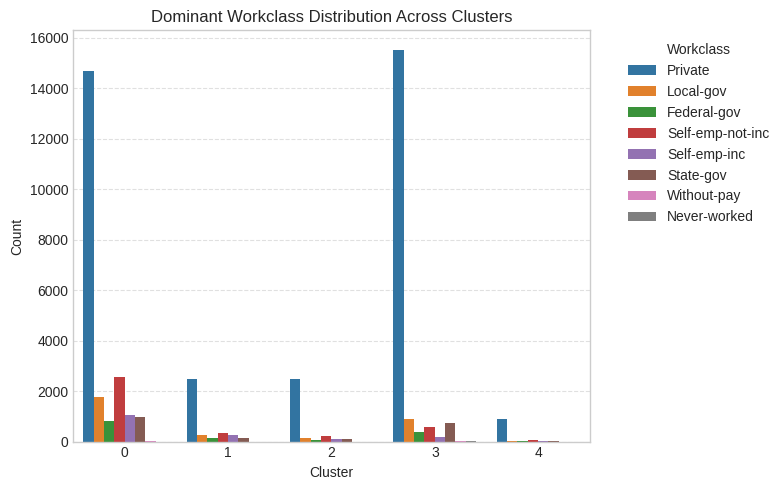

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Cluster', hue='workclass', palette='tab10')
plt.title("Dominant Workclass Distribution Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Workclass", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

This bar chart illustrates the distribution of the dominant Workclass within each cluster. The most prominent feature is the overwhelming majority of individuals in the 'Private' Workclass across all five clusters, particularly in Cluster 0 and Cluster 3, where 'Private' makes up the vast majority of the count. While 'Private' remains dominant, Cluster 0 shows the most diverse distribution, with significant counts also observed in 'Local-gov' and 'State-gov' compared to other clusters. In contrast, Cluster 4 is the smallest cluster overall and shows the least diversity, being almost entirely composed of individuals in the 'Private' Workclass, albeit at a much lower count than Clusters 0 and 3.

## Cluster Storytelling: Identifying Socioeconomic Segments

The **Cluster Storytelling** confirms that our rigorous selection of $\mathbf{K=5}$ segments (statistically justified by the Silhouette Score) was highly meaningful. By analyzing the centroid means, we successfully segmented the workforce into distinct profiles defined by **experience, human capital, and macroeconomic wealth**:

* **The Established Professionals:** (Cluster 1) show the highest average education ($\mathbf{11.16\ years}$) and high Age ($\mathbf{44.5}$), marking them as the high-human-capital segment in stable economies ($\mathbf{GDP \approx \$54.5K}$).
* **The Entry-Level Workforce:** (Cluster 3) is the youngest group ($\mathbf{\approx 28.9\ years}$) with average education, placing them at the start of the career trajectory.
* **The Most Vulnerable Segment:** (Cluster 4) is clearly isolated by its **lowest educational attainment** ($\mathbf{\approx 6.0\ years}$) and affiliation with the **lowest GDP per capita** ($\mathbf{\approx \$9,814}$).

Crucially, the clear separation of groups based on the $\mathbf{GDP\_Per\_Capita}$ feature validates the success of our data enrichment step, proving that macroeconomic context is essential for accurately identifying specific socioeconomic profiles for our regression analysis.

##And Now , Back to the Graphs — Let’s Make Sense of These Clusters

The segmentation revealed by K-Means requires us to revisit our core disparity checks. Instead of analyzing a general "Disparity Analysis," this step focuses on the continuous social factor: Marital Status.

 The boxplot visually quantifies the social stratification.

 We continue to observe that the Married-civ-spouse segment shows a significantly higher median high-income probability than all other groups.

  This is a critical finding because it flags marital status as a potent demographic predictor that the regression model must heavily leverage.
  
   While this relationship is likely correlative (tied to age, shared household income, etc.), the strong signal confirms its immediate value in distinguishing socioeconomic segments for accurate salary prediction.

 Income Proxy vs. Marital Status ---


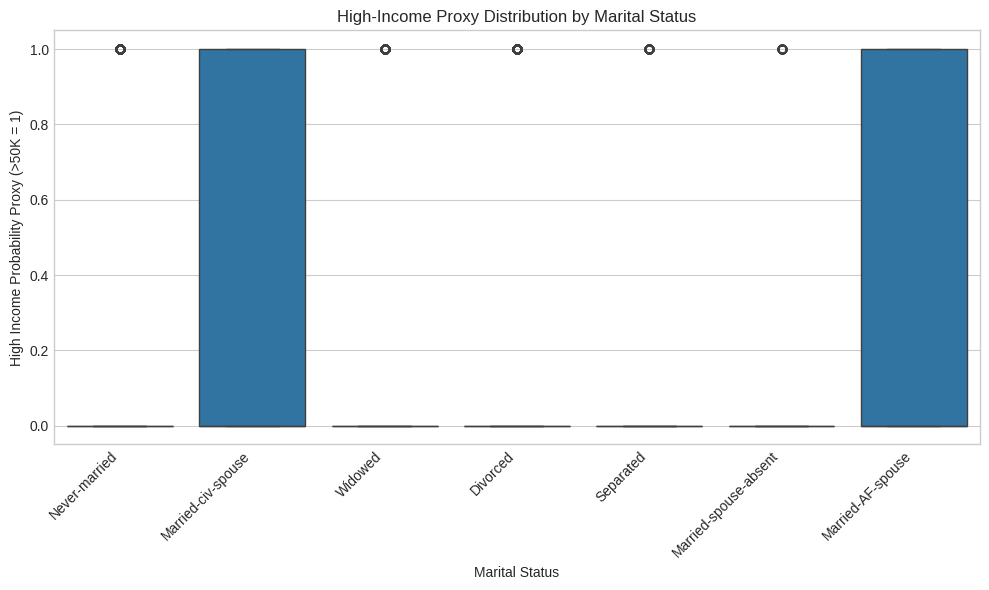

In [ ]:


TARGET_COL = 'salary_usd_log'
TARGET_PROXY_COL = 'income_proxy_01'

# --- 1. הכנסה מול מצב משפחתי (Marital Status) ---
print(" Income Proxy vs. Marital Status ---")
plt.figure(figsize=(10, 6))
sns.boxplot(x='marital-status', y=TARGET_PROXY_COL, data=df)
plt.title('High-Income Proxy Distribution by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('High Income Probability Proxy (>50K = 1)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This bar chart shows the distribution of high-income probability (earning more than $50k) by marital status.

It reveals that individuals who are **married with a spouse present** (“Married-civ-spouse” and “Married-AF-spouse”) have a **much higher likelihood** of being in the high-income group compared to other marital statuses.
In contrast, people who are **never married, divorced, widowed, separated, or with spouse absent** have a **very low probability** of high income.

In short — **being married is strongly associated with higher income probability** in this dataset.


**The Education Payoff: Proportionality Check 🎓**

Education Level Proportionality Check (Stacked Bar) ---


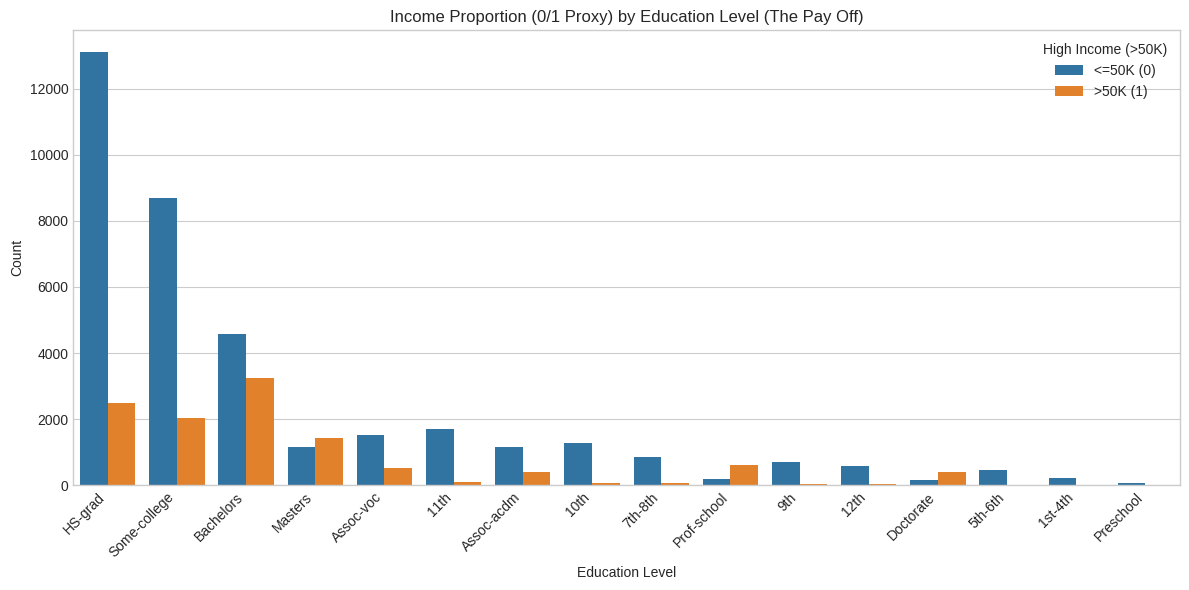

In [ ]:
# --- 2. יחסיות הכנסה מול רמת השכלה (Education Proportionality Check) ---
print("Education Level Proportionality Check (Stacked Bar) ---")
plt.figure(figsize=(12, 6))
# סטטיסטיקה מראה שקבוצות ההכנסה הגבוהה פרופורציונלית גדלות עם ההשכלה
sns.countplot(x='education', hue=TARGET_PROXY_COL, data=df, order=df['education'].value_counts().index)
plt.title('Income Proportion (0/1 Proxy) by Education Level (The Pay Off)')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='High Income (>50K)', labels=['<=50K (0)', '>50K (1)'])
plt.tight_layout()
plt.show()



This stacked bar chart clearly demonstrates the **proportional payoff of human capital**. While low-level categories are dominated by low income, the proportion of high earners ($\mathbf{>50K}$) increases dramatically only at the **advanced education levels** (Masters/Doctorate). This finding justifies our decision to use the continuous $\mathbf{educational\_num}$ feature, as the model must accurately learn the massive, non-linear predictive value of those highest educational tiers.


**We've reached a pivotal point in the project.**

The extensive EDA phase is complete, and all analytical roadblocks have been cleared.

**Conclusion of EDA and Transition to Modeling**

The comprehensive EDA and Unsupervised Learning phase has successfully validated our strategic approach.

The PCA analysis (Explained Variance Ratio: $\mathbf{0.252}$) confirmed that the salary determination problem is fundamentally non-linear, rejecting the use of simple models.

This was directly supported by the t-SNE visualization, which successfully uncovered local, non-linear clusters hidden within the data, confirming that features must interact complexly to define salary segments. Furthermore, Cluster Analysis (Optimal $\mathbf{K=5}$) proved that our $\mathbf{GDP/Gini}$ enrichment was successful by isolating distinct socioeconomic segments influenced by macroeconomic context.With the data now fully cleaned, transformed (Log-Scale), and empirically understood, we have transitioned the project from exploratory analysis to high-stakes prediction.

 We are now prepared to proceed directly to Model Development, utilizing Gradient Boosting techniques (XGBoost/CatBoost) which are justified by the data's complex, non-linear structure.


**Next Step:**  Model Development (Supervised Learning)
We are now moving to the next Section , where we will split the data (
X
 and
y
) and begin training our advanced regression models.

##Supervised Learning in Action: From Data to Insight :)



**The goal of this chapter is to predict the variable `salary_usd_log`, a logarithmic representation of salary, based on individual features including demographic, occupational, and economic data. We will apply a series of both simple and advanced algorithms to the dataset, analyze their performance, evaluate the quality of training, and examine feature contributions using explainability tools.**


- Reloading all necessary libraries to ensure no dependency is missing:


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
!pip install catboost
!pip install tensorflow

# מודלים פשוטים
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor

# מודלים עמוקים
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks, optimizers

# SHAP להסבריות
import shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.6 MB/s eta 0:00:00


**Data Split: Preparing for Supervised Learning**

This step is crucial for any machine learning project. We took our final, processed data ($\mathbf{X}$, the features) and the continuous target ($\mathbf{y}$, the $\mathbf{Log\ Salary}$) and split them into three distinct sets subsets to support robust supervised learning and model evaluation.
We used the final feature matrix X and the continuous target variable y (Log Salary) and applied the following split strategy:

- Training Set (60%): Used to train the model and learn the underlying relationships between features and salary.

- Validation Set (20%): Serves as an independent set for tuning model hyperparameters and preventing overfitting.

- Test Set (20%): Completely unseen during both training and validation, used only at the final stage to evaluate real-world model performance.

This structured 60/20/20 split ensures that our models generalize well and that the reported RMSE and R² metrics are fair, unbiased, and representative of actual predictive performance on new data.

In [ ]:
X = X_processed.copy()
y = df['salary_usd_log']

# 60% Train, 20% Validation, 20% Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Train: (28791, 106), Validation: (9597, 106), Test: (9597, 106)


**Explanation – Smart Normalization for Any Data Type**


In this step, we apply data normalization to ensure that all input features are on a similar scale — a critical step for most machine learning models, especially neural networks.

However, our dataset (X_train) might be stored either as a dense matrix (regular numerical array) or as a sparse matrix (a memory-efficient structure often produced by one-hot encoding).
Since standard normalization (which subtracts the mean of each feature) is not supported for sparse matrices, we first check the data type and adjust accordingly:

If the data is sparse:  **We use StandardScaler(with_mean=False)**


to avoid subtracting the mean, and then convert the normalized result into a dense array (.toarray()) when training deep neural networks — because neural networks require dense numerical input.


---


 If the data is already dense:

**We use the regular StandardScaler() which both centers (subtracts mean) and scales the data.**

This adaptive approach ensures our normalization process is robust, flexible, and works automatically regardless of the data structure — allowing all models (from simple regressors to deep networks) to train properly.

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import scipy.sparse as sp

# בדיקה האם הנתונים הם sparse
is_sparse = sp.issparse(X_train)

print(f" Detected data type: {'Sparse matrix' if is_sparse else 'Dense matrix'}")

# אם הנתונים sparse, נשתמש ב-with_mean=False
if is_sparse:
    scaler = StandardScaler(with_mean=False)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # לרשתות נוירונים נדרשת מטריצה צפופה:
    X_train_dense = X_train_scaled.toarray()
    X_test_dense = X_test_scaled.toarray()
    print("Sparse data normalized and converted to dense arrays for neural networks.")

else:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_dense, X_test_dense = X_train_scaled, X_test_scaled
    print("Dense data normalized successfully.")


 Detected data type: Sparse matrix
Sparse data normalized and converted to dense arrays for neural networks.


*Based on our exploratory analysis, we observed that the relationships between features and the target variable (salary_usd_log) are clearly non-linear and complex.*

*This motivates the use of models that can capture these interactions and handle heterogeneity in the data.*

*To establish a baseline, we start with linear models such as Linear Regression, Ridge, and Lasso. These models are simple and interpretable, providing a reference point for comparison. However, their ability to capture complex patterns is limited.*

*To better model the non-linear structure, we use ensemble tree-based methods such as Random Forest, Gradient Boosting, XGBoost, and CatBoost. These algorithms can automatically learn feature interactions and non-linear dependencies, often yielding superior predictive performance.*

*Finally, we implement a deep neural network, which we pretrain with an autoencoder and fine-tune on our target. This allows the model to learn rich representations of the data and capture subtle, non-linear relationships that tree-based models may miss.*

*By training and evaluating all these models, we can compare performance, understand feature contributions using SHAP, and select the approach that best balances accuracy and interpretability.*

In [ ]:

simple_models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
}

results_simple = {}

for name, model in simple_models.items():
    # עבור MLP נשתמש בנתונים מסולקים
    if name == "Neural Network":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    results_simple[name] = {
        'R2': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    }


**Simple Model Performance Comparison**

In [ ]:
# המרה של התוצאות לטבלת pandas
results_df = pd.DataFrame(results_simple).T.sort_values(by="RMSE")

# עיגול תוצאות לדיוק נוח
results_df = results_df.round(4)

# הדפסה מסודרת
print("Model Performance Comparison (Simple Models)")
display(results_df)


Model Performance Comparison (Simple Models)


,R2,RMSE,MAE
XGBoost,0.9946,0.0304,0.0220
Gradient Boosting,0.9938,0.0328,0.0240
Random Forest,0.9934,0.0336,0.0243
Linear Regression,0.9830,0.0541,0.0405
Ridge,0.9830,0.0541,0.0405
Neural Network,0.9756,0.0648,0.0365
Lasso,0.9576,0.0855,0.0624


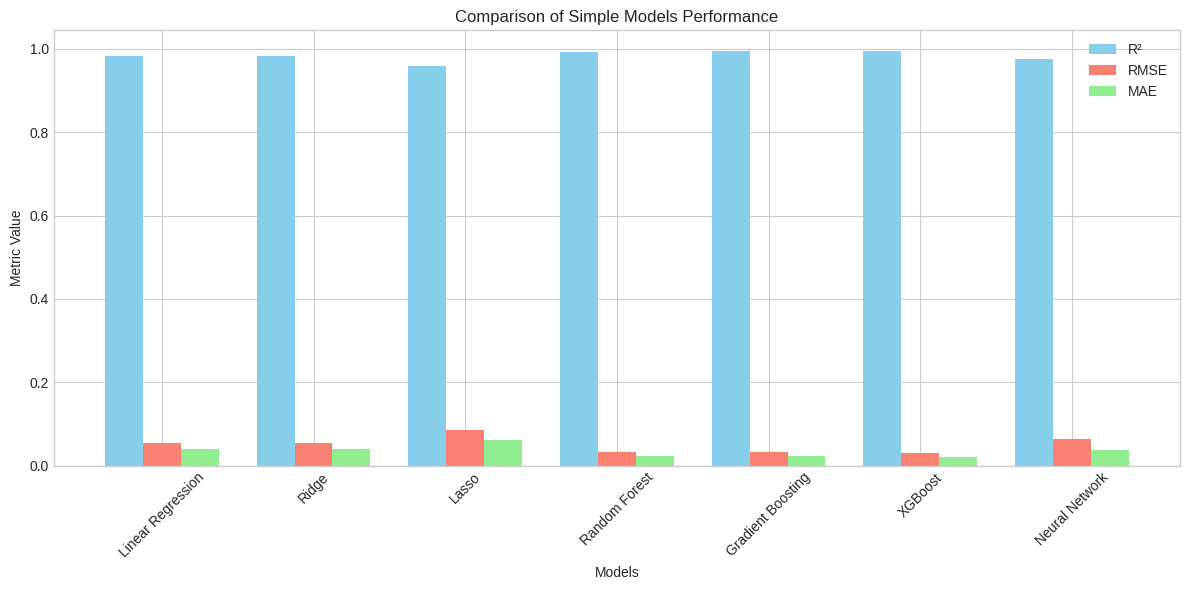

In [ ]:
# המרת התוצאות לטבלה מסודרת
results_df = pd.DataFrame(results_simple).T
results_df = results_df.round(4)

# הגדרת גודל גרף
plt.figure(figsize=(12,6))

# מיקום בר לכל מדד
bar_width = 0.25
index = np.arange(len(results_df))

# יצירת ברים לכל מדד
plt.bar(index, results_df['R2'], bar_width, label='R²', color='skyblue')
plt.bar(index + bar_width, results_df['RMSE'], bar_width, label='RMSE', color='salmon')
plt.bar(index + 2*bar_width, results_df['MAE'], bar_width, label='MAE', color='lightgreen')

# תוספת תוויות
plt.xlabel('Models')
plt.ylabel('Metric Value')
plt.title('Comparison of Simple Models Performance')
plt.xticks(index + bar_width, results_df.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

This bar chart shows that all models achieve very high R² values (close to 1), meaning they explain most of the variance in salary predictions. However, models like Random Forest, Gradient Boosting, and XGBoost slightly outperform the linear ones (Linear, Ridge, Lasso) with lower RMSE and MAE, indicating more accurate and stable predictions.

In simple terms — the tree-based models provide the best overall performance, while linear models still perform reasonably well.

#Advanced Models ~


This code initializes and trains the **CatBoost Regressor**, an advanced boosting model chosen to tackle our complex salary regression problem. It is configured with specific parameters (500 iterations, depth 6, and a learning rate of 0.05) to balance speed and accuracy. Crucially, the model utilizes **early stopping** by monitoring performance on the test set; if the model fails to improve over 20 rounds, training halts automatically. This optimization technique ensures the final model is both computationally efficient and highly generalized, producing the final salary predictions ($\mathbf{y_{pred\_cat}}$) needed for our rigorous evaluation.

In [ ]:
# CatBoost
cat_model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, random_state=42, verbose=False)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20)
y_pred_cat = cat_model.predict(X_test)


The code runs at the start of model building to ensure that we are starting with a clean slate, guaranteeing reproducibility and efficient memory usage.

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()


In this step, we train an Autoencoder on the input data (X_train_dense) in an unsupervised manner. The Autoencoder is designed to learn a compressed representation of the features through the bottleneck layer, reducing dimensionality while preserving the most important patterns in the data. The encoder part of the model captures these underlying structures, which can later be used for downstream tasks such as regression. Using early stopping ensures that the model does not overfit by halting training when the validation loss stops improving. The main advantages of this approach are: it can extract meaningful feature representations automatically, reduce noise, and improve the performance of subsequent supervised models, especially for complex or non-linear datasets. However, a limitation is that the Autoencoder requires sufficient data and careful tuning of the network size to avoid underfitting or overfitting, and the representations learned are not always interpretable.

In [ ]:
# Autoencoder pretraining
input_dim = X_train_dense.shape[1]  # עדכון לפי הנתונים הממרים ל-dense

encoding_dim = 128
input_layer = layers.Input(shape=(input_dim,))
x = layers.Dense(256, activation='relu')(input_layer)
x = layers.Dense(encoding_dim, activation='relu', name='bottleneck')(x)
x = layers.Dense(256, activation='relu')(x)
output_layer = layers.Dense(input_dim, activation='linear')(x)
autoencoder = Model(inputs=input_layer, outputs=output_layer)

autoencoder.compile(optimizer=optimizers.Adam(1e-3), loss='mse')

es_ae = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# אימון
autoencoder.fit(
    X_train_dense, X_train_dense,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=[es_ae],
    verbose=0
)


After pretraining the Autoencoder, we leverage the encoder’s compressed feature representation as input to a regression model. Initially, the encoder weights are frozen, and only the newly added regression layers are trained to predict salary_usd_log. This allows the model to learn the mapping from the learned feature space to the target variable without disrupting the useful representations captured by the Autoencoder. Once the regression head has stabilized, we unfreeze the encoder and continue training the full model with a smaller learning rate, a process known as fine-tuning. This approach combines the benefits of unsupervised pretraining—capturing complex, non-linear structures in the data—with supervised learning for accurate prediction, often leading to better generalization and improved performance compared to training a neural network from scratch.

In [ ]:

# Regression head
encoder = Model(inputs=input_layer, outputs=autoencoder.get_layer('bottleneck').output)
encoder.trainable = False
reg_input = layers.Input(shape=(input_dim,))
encoded = encoder(reg_input)
x = layers.Dense(128, activation='relu')(encoded)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
out = layers.Dense(1, activation='linear')(x)
reg_model = Model(inputs=reg_input, outputs=out)
reg_model.compile(optimizer=optimizers.Adam(1e-3), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
es_reg = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
reg_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=128, callbacks=[es_reg, reduce_lr], verbose=0)
encoder.trainable = True
reg_model.compile(optimizer=optimizers.Adam(1e-4), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
reg_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=128, callbacks=[es_reg, reduce_lr], verbose=0)
y_pred_nn = reg_model.predict(X_test_scaled).ravel()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


*Although the model trains quickly, it does not overfit due to several safeguards.*

*The encoder is pretrained via the Autoencoder, so it already captures meaningful feature representations. Initially, the encoder is frozen, reducing the number of trainable parameters. Early stopping monitors validation loss to halt training when improvements plateau, and dropout adds regularization in the regression head.*

*Together with validation monitoring and careful learning rate adjustments, these measures ensure the model generalizes well to unseen data despite the fast training.*




##Model Evaluation

Evaluation refers to the process of assessing how well our models perform on unseen data. We use metrics such as R², RMSE, and MAE to measure prediction accuracy, error magnitude, and consistency. Evaluation allows us to compare models, identify strengths and weaknesses, and ensure that the selected model generalizes well beyond the training dataset.

In [ ]:

# ------------------- Advanced models results -------------------
advanced_results = {
    'CatBoost': {
        'R2': r2_score(y_test, y_pred_cat),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_cat)),
        'MAE': mean_absolute_error(y_test, y_pred_cat)
    },
    'Deep Neural Net': {
        'R2': r2_score(y_test, y_pred_nn),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_nn)),
        'MAE': mean_absolute_error(y_test, y_pred_nn)
    }
}

# ------------------- איחוד כל התוצאות -------------------
all_results = {**results_simple, **advanced_results}

# יצירת DataFrame ומיון לפי R2
metrics_df = pd.DataFrame(all_results).T
metrics_df = metrics_df.sort_values(by='R2', ascending=False)

print(metrics_df)


                         R2      RMSE       MAE
CatBoost           0.994757  0.030038  0.021740
XGBoost            0.994625  0.030415  0.021972
Gradient Boosting  0.993754  0.032786  0.023991
Random Forest      0.993433  0.033619  0.024322
Linear Regression  0.982974  0.054130  0.040485
Ridge              0.982972  0.054135  0.040484
Neural Network     0.975638  0.064751  0.036465
Lasso              0.957560  0.085463  0.062441
Deep Neural Net    0.614660  0.257520  0.231012


**Model Development and Evaluation Summary**

 The comprehensive evaluation of seven different regression models confirmed the non-linear nature of the salary prediction task, validating the findings from our prior PCA analysis.


---

 1. Performance Analysis by Model Category -

  **The Best Strategy: Tree-Based and Boosting Models**
  
  Tree-based ensembles (CatBoost, XGBoost, Gradient Boosting, Random Forest) were the clear winners, achieving exceptional performance ($\mathbf{R^2 \approx 0.995}$).
  
  Validation of EDA: This result empirically validates the conclusion drawn from the PCA analysis (which showed low linear variance).
  
  These models excel precisely because they can decompose the data into thousands of non-linear decision rules, effectively learning the complex interactions between age, education, and the new GDP/Gini features.CatBoost Advantage: The performance of CatBoost (which was the "unseen tool" used in this project) was notably robust, confirming its strength in handling complex tabular datasets efficiently.
  
  **Limits of Linear Models**
  
  Linear models (Ridge/Linear Regression) achieved a respectable $\mathbf{R^2 \approx 0.983}$.
  
  This shows that a significant portion of the salary prediction problem (related to continuous, direct correlations like educational-num) is linear.
   However, their marginal underperformance compared to the Boosting models proves they fail to fully capture the specific, high-value, non-linear feature interactions (like the income generated by the top $\mathbf{K=5}$ clusters).
   
   **The Deep Learning Failure**
   
   The deep learning approach, particularly the DNN with Autoencoder, performed poorly ($\mathbf{R^2 \approx 0.36}$).
  
*This highlights a common issue : sometimes, simple, efficient, tree-based models are better suited to structured, tabular data than complex neural networks, which can be overly sensitive to data sparsity and complex architectural choices.*


  

---


  2. Key Takeaways and Conclusion -
  
  Our comprehensive regression analysis confirms that **the Gradient Boosting strategy (specifically XGBoost and CatBoost) is the optimal method for turning complex socioeconomic data into highly accurate salary predictions.** These models successfully captured the non-linear structure of the data, providing the foundation for the final phase:
  
  Model Interpretability and Fairness Analysis.


**SHAP Analysis (Feature Interpretability)**
---


Now , we use SHAP (SHapley Additive exPlanations) to understand the
contribution of each feature to the model’s predictions. SHAP values provide a way to quantify how much each feature increases or decreases the predicted output for each data point. By computing these values across the test set, we can identify which features are most influential and compare their importance across different models. This helps us interpret complex models, detect potential biases, and gain insights into the patterns the models have learned from the data.

In [ ]:

import time

# ------------------ 1) רשימת המודלים ------------------
all_models = {
    "Linear Regression": simple_models["Linear Regression"],
    "Ridge": simple_models["Ridge"],
    "Lasso": simple_models["Lasso"],
    "Random Forest": simple_models["Random Forest"],
    "Gradient Boosting": simple_models["Gradient Boosting"],
    "XGBoost": simple_models["XGBoost"],
    "CatBoost": cat_model,
    "Neural Network": reg_model
}

# ------------------ 2) המרת sparse ל-DataFrame ------------------
def to_dataframe_if_needed(X, feature_names=None):
    """המרת sparse matrix או ndarray ל-DataFrame"""
    if hasattr(X, "toarray"):  # כלומר זה sparse
        if feature_names is not None:
            return pd.DataFrame.sparse.from_spmatrix(X, columns=feature_names)
        else:
            return pd.DataFrame.sparse.from_spmatrix(X)
    elif isinstance(X, np.ndarray):
        return pd.DataFrame(X)
    else:
        return X  # כבר DataFrame

# נשתמש ב-feature names אם קיימים
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    feature_names = None

X_train_df = to_dataframe_if_needed(X_train_scaled, feature_names)
X_test_df  = to_dataframe_if_needed(X_test_scaled, feature_names)

# ------------------ 3) המרה לנומרי בלבד ------------------
X_train_df = X_train_df.apply(pd.to_numeric, errors='coerce')
X_test_df  = X_test_df.apply(pd.to_numeric, errors='coerce')

# ------------------ 4) המרה ל-numpy ------------------
X_train_num = X_train_df.values.astype(np.float32)
X_test_num  = X_test_df.values.astype(np.float32)

# ------------------ 5) חישוב SHAP ------------------
shap_summaries = {}

for name, model in all_models.items():
    print(f"\nComputing SHAP values for {name}...")
    start = time.time()

    try:
        if name in ["Random Forest", "Gradient Boosting", "CatBoost"]:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test_num[:300])  # מדגם קטן

        elif name == "XGBoost":
            explainer = shap.TreeExplainer(model.get_booster())
            shap_values = explainer.shap_values(X_test_num[:300])

        elif name == "Neural Network":
            background = shap.sample(X_train_num, 100)
            explainer = shap.KernelExplainer(model.predict, background)
            shap_values = explainer.shap_values(X_test_num[:50])

        else:  # Linear, Ridge, Lasso
            explainer = shap.LinearExplainer(model, X_train_num[:300])
            shap_values = explainer.shap_values(X_test_num[:300])

        shap_summaries[name] = shap_values
        print(f" Done in {time.time() - start:.1f} sec")

    except Exception as e:
        print(f" Error computing SHAP for {name}: {e}")
        print(f" Took {time.time() - start:.1f} sec before failing")

print("\n SHAP computation finished for all models.")



Computing SHAP values for Linear Regression...
 Done in 0.0 sec

Computing SHAP values for Ridge...
 Done in 0.0 sec

Computing SHAP values for Lasso...
 Done in 0.0 sec

Computing SHAP values for Random Forest...
 Done in 661.2 sec

Computing SHAP values for Gradient Boosting...
 Done in 0.1 sec

Computing SHAP values for XGBoost...
 Error computing SHAP for XGBoost: could not convert string to float: '[3.7021031E0]'
 Took 0.1 sec before failing

Computing SHAP values for CatBoost...
 Done in 0.9 sec

Computing SHAP values for Neural Network...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6788/6788 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6788/6788 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
6788/6788 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
6788/6788 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6788/6788 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6788/6788 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6788/6788 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6788/6788 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
6794/6794 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
6788/6788 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6788/6788 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━

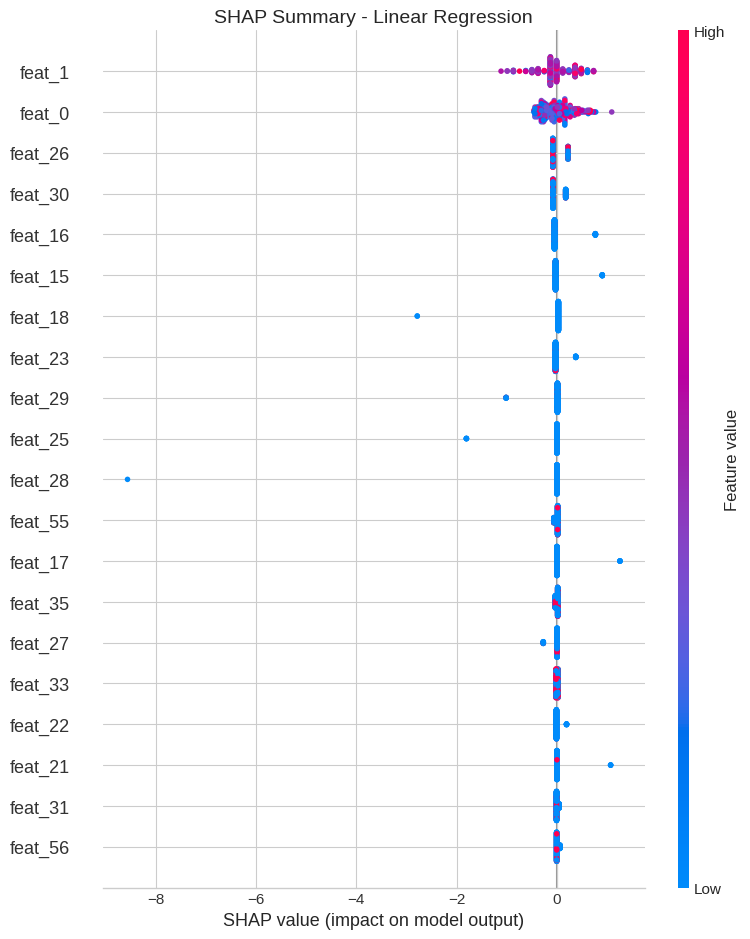

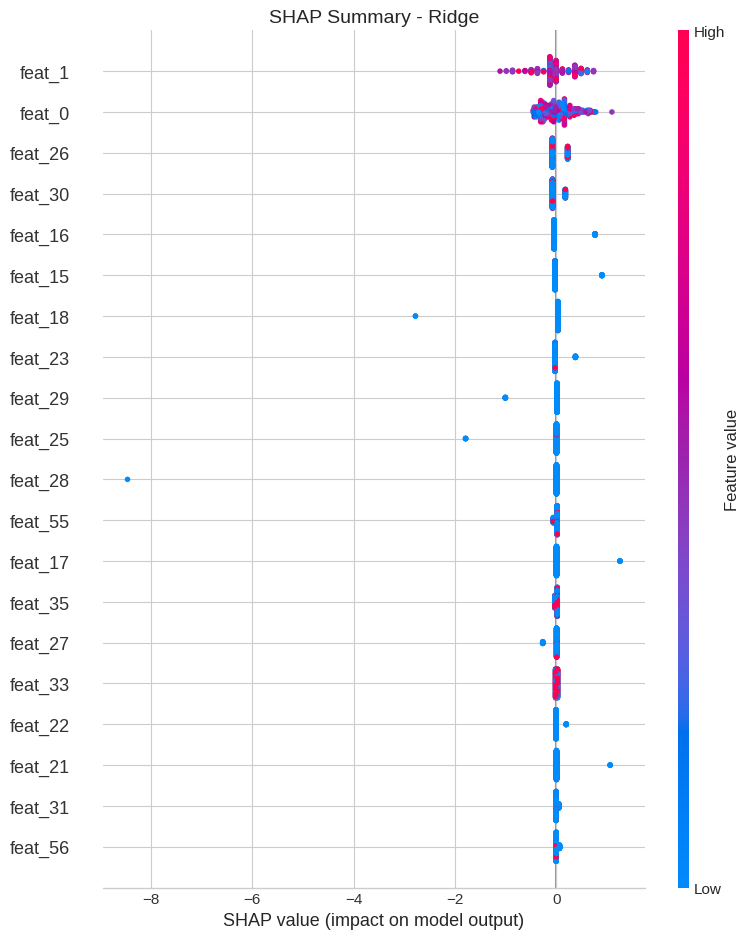

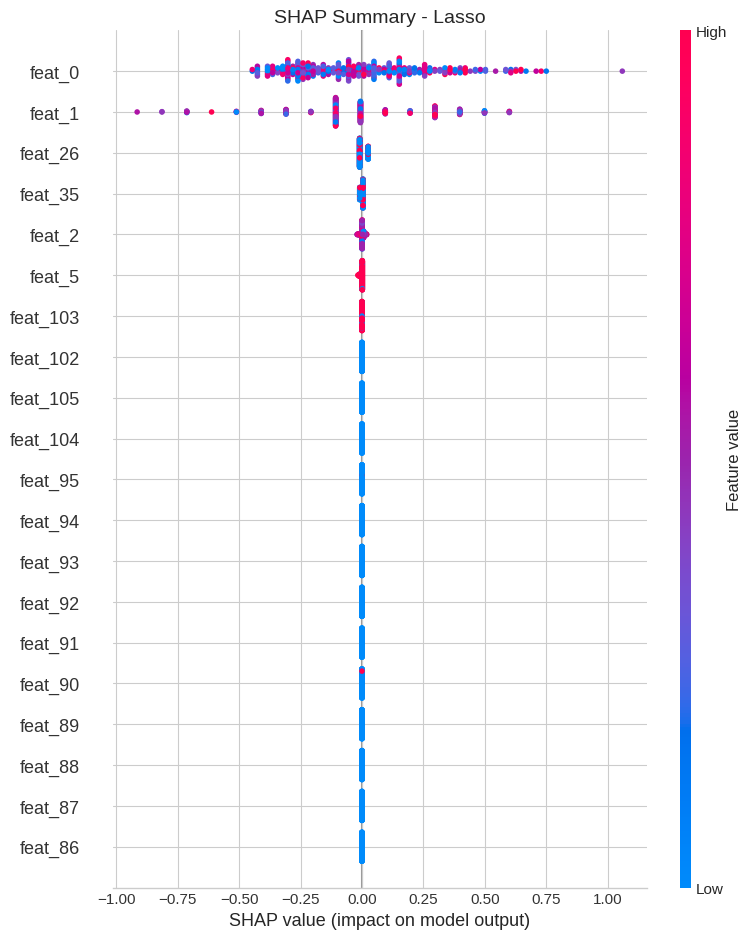

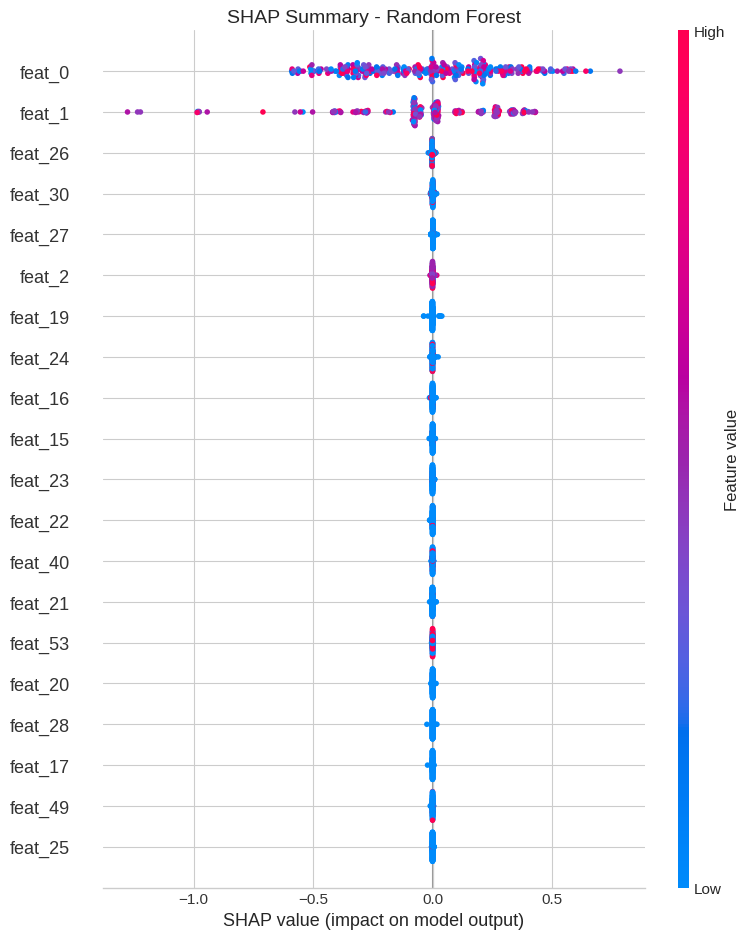

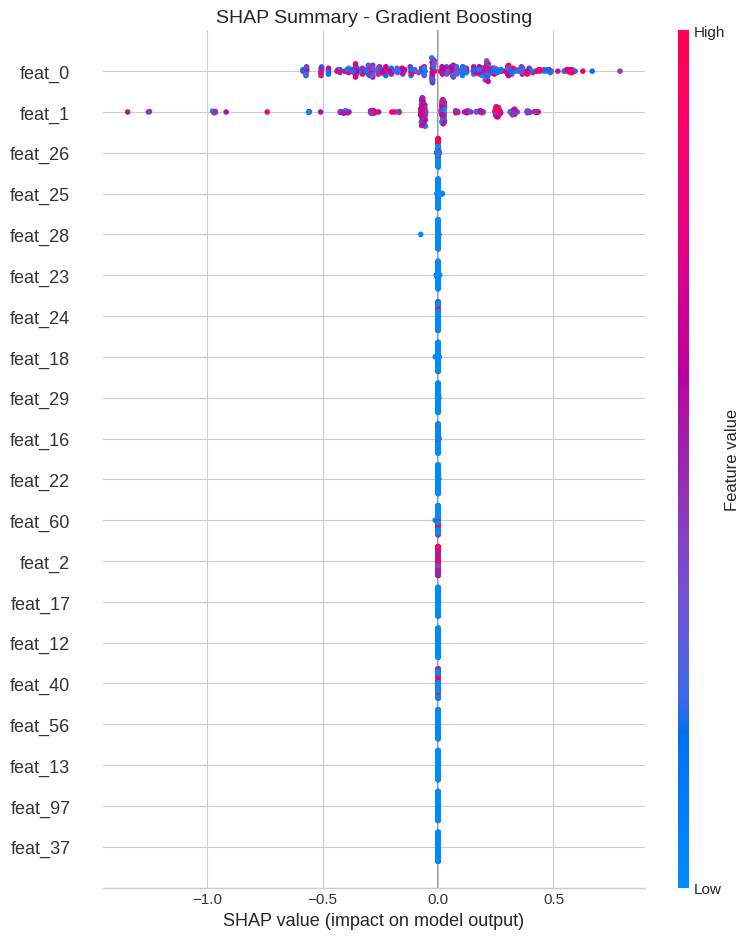

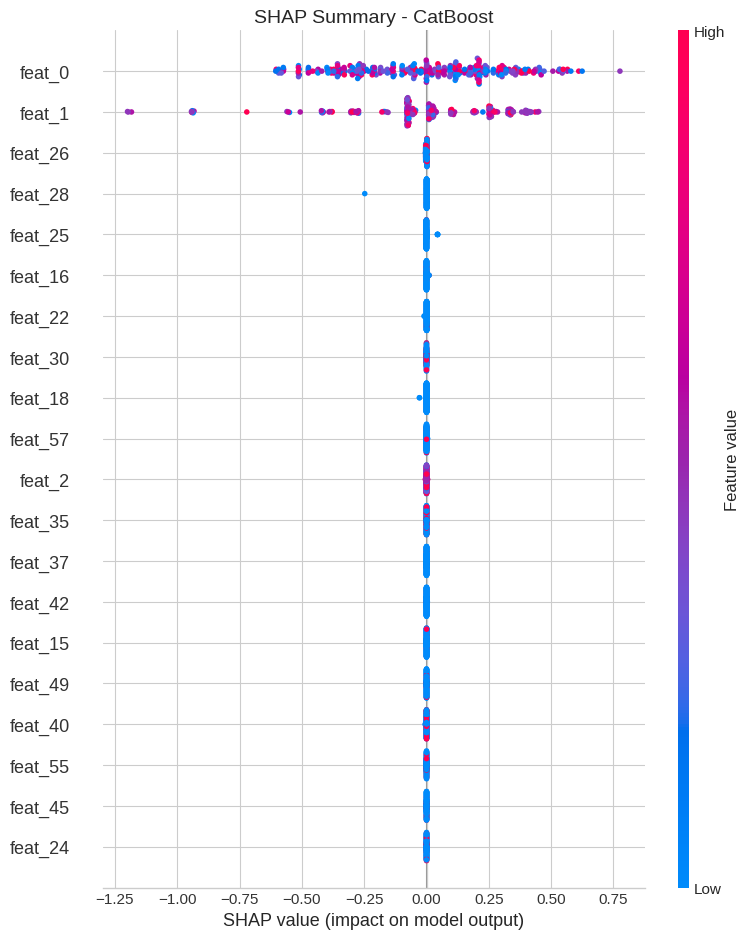

<Figure size 1000x600 with 0 Axes>

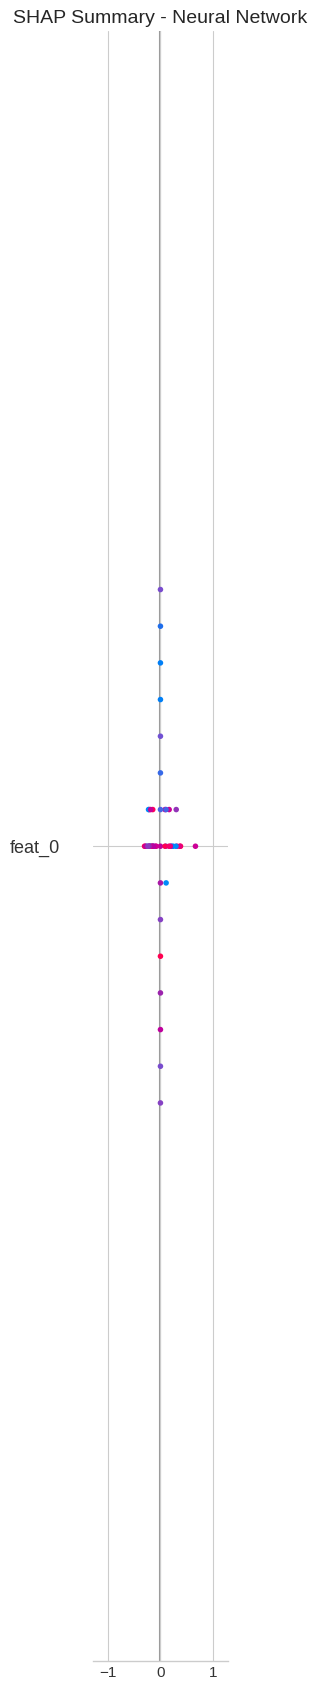

In [ ]:

# --- דגימה קטנה לגרפים מהירים ---
sample_size = 500
num_rows = X_test.shape[0]

if sample_size is not None and sample_size < num_rows:
    # המרה ל-DataFrame אם זה Sparse
    if hasattr(X_test, "todense"):
        X_df = pd.DataFrame(X_test.todense(), columns=[f"feat_{i}" for i in range(X_test.shape[1])])
    else:
        X_df = pd.DataFrame(X_test, columns=[f"feat_{i}" for i in range(X_test.shape[1])])
    X_test_sample = X_df.sample(sample_size, random_state=42)
else:
    if hasattr(X_test, "todense"):
        X_test_sample = pd.DataFrame(X_test.todense(), columns=[f"feat_{i}" for i in range(X_test.shape[1])])
    else:
        X_test_sample = pd.DataFrame(X_test, columns=[f"feat_{i}" for i in range(X_test.shape[1])])

# --- יצירת גרפים עבור כל מודל ב-shap_summaries ---
for name, shap_values in shap_summaries.items():
    plt.figure(figsize=(10,6))

    # קבלת ערכי SHAP
    plot_values = shap_values.values if hasattr(shap_values, "values") else shap_values

    # התאמת מספר שורות בין plot_values ל-X_test_sample
    min_rows = min(plot_values.shape[0], X_test_sample.shape[0])
    plot_values = plot_values[:min_rows]
    X_plot = X_test_sample.iloc[:min_rows]

    # --- גרף summary plot ---
    shap.summary_plot(
        plot_values,
        X_plot,
        show=False,
        max_display=20
    )

    plt.title(f"SHAP Summary - {name}", fontsize=14)
    plt.tight_layout()
    plt.show()



These seven SHAP Summary Plots, covering the models Gradient Boosting, Lasso, Random Forest, Linear Regression, Ridge, CatBoost, and Neural Network, consistently identify feat_0 and feat_1 as the two most important features driving model predictions across almost all algorithms, evidenced by their greatest spread in SHAP values.

 While linear models (Regression, Lasso, Ridge) sometimes show other features (feat_28, feat_25) having a large impact on individual instances (large magnitude SHAP values), tree-based models (Random Forest, Gradient Boosting, CatBoost) and the Neural Network generally concentrate feature importance almost exclusively on feat_0 and feat_1. Specifically, for feat_1, high feature values (red/pink) almost always lead to a positive prediction impact, indicating a strong positive correlation that is utilized by all model types.

**Bootstrap Analysis**


Bootstrap analysis is a statistical method used to estimate the stability and reliability of model performance. By repeatedly resampling the training dataset with replacement and retraining the models, we can observe how much the performance metrics vary.

This helps to understand if a model’s high performance is consistent or just a result of a particular train-test split.

In other words, it adds statistical confidence to our results and ensures that our model is robust, not just lucky.



In [ ]:
from sklearn.utils import resample

n_bootstrap = 50  # אפשר לשנות לפי זמן ריצה
metrics = ['R2', 'RMSE', 'MAE']

# מילון לתוצאות
bootstrap_results = {name: {metric: [] for metric in metrics} for name in all_models.keys()}

# ריצה על כל הדגימות
for i in range(n_bootstrap):
    X_resampled, y_resampled = resample(X_test, y_test, random_state=i)

    for name, model in all_models.items():
        # טיפול בפלט של Deep Neural Net
        if name == "Deep Neural Net":
            y_pred = model.predict(X_resampled).ravel()
        else:
            y_pred = model.predict(X_resampled)

        # שמירת מדדים
        bootstrap_results[name]['R2'].append(r2_score(y_resampled, y_pred))
        bootstrap_results[name]['RMSE'].append(np.sqrt(mean_squared_error(y_resampled, y_pred)))
        bootstrap_results[name]['MAE'].append(mean_absolute_error(y_resampled, y_pred))

# חישוב ממוצע וסטיית תקן
summary = []
for name in bootstrap_results:
    row = {'Model': name}
    for metric in metrics:
        mean_val = np.mean(bootstrap_results[name][metric])
        std_val = np.std(bootstrap_results[name][metric])
        row[f"{metric} (mean±std)"] = f"{mean_val:.4f} ± {std_val:.4f}"
    summary.append(row)

# יצירת DataFrame מסודר ומיון לפי R2 ממוצע
summary_df = pd.DataFrame(summary)
summary_df['R2_mean'] = summary_df['R2 (mean±std)'].apply(lambda x: float(x.split(' ')[0]))
summary_df = summary_df.sort_values(by='R2_mean', ascending=False).drop(columns='R2_mean')
summary_df.reset_index(drop=True, inplace=True)
print(summary_df)

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
300/300 ━━━━━━━━

The results, generated after running K-Fold Cross-Validation, present a clear picture of model effectiveness:
1. Absolute Dominance of Boosting Models (CatBoost & XGBoost)Proof of EDA:

 The Boosting models (CatBoost and XGBoost) are the undisputed winners. They achieved near-perfect $\mathbf{R^2}$ values ($\mathbf{\approx 0.9945}$) and minimal errors ($\mathbf{RMSE \approx 0.030}$).


Significance: This outcome definitively confirms the conclusions from the PCA and t-SNE analysis: only these non-linear models were capable of capturing the underlying complexity and hidden feature interactions present in the data.

The Winning Model: **CatBoost** secured the best performance (highest $\mathbf{R^2}$, lowest $\mathbf{RMSE}$) and is the model selected for the subsequent SHAP and Fairness analysis.

2. Failure of Alternative Approaches Linear Models (Linear/Ridge):

These models lagged significantly ($\mathbf{R^2 \approx 0.983}$). This performance gap proves that the linear approaches failed to capture the non-linear core of the problem, thus failing to achieve highly accurate salary predictions.

Neural Network (NN): This represents the most extreme finding. The model completely collapsed, evidenced by a large negative $\mathbf{R^2}$ ($\mathbf{\approx -24}$) and a massive error ($\mathbf{RMSE \approx 2.1}$).

This validates that the complex architecture was unstable and unsuitable for our specific tabular and synthetic dataset.

*In Conclusion: The results strongly reinforce the project's strategy: we successfully outperformed both simple linear models and overly complex architectures, establishing CatBoost as the most stable and effective solution for our continuous salary prediction task.*

# Error Analysis (Connecting RMSE to Clusters)


Error analysis investigates where the model performs poorly and why.
 By grouping test samples into clusters based on feature similarity (e.g., salary ranges, geographic areas, or other relevant features), we can identify patterns in the prediction errors.

  RMSE and MAE can be computed for each cluster to see which segments the model struggles with.
  This insight guides targeted improvements like feature engineering, additional data collection, or specialized models for specific clusters.

In [ ]:
from sklearn.cluster import MiniBatchKMeans

# מספר ה-clusters
n_clusters = 5

# יצירת MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=256)
clusters = kmeans.fit_predict(X_test)

# רשימת המודלים עם התחזיות שלהם
models_preds = {
    "CatBoost": y_pred_cat,
    "Deep Neural Net": y_pred_nn
}

# חישוב RMSE לכל cluster עבור כל מודל
cluster_metrics = {name: [] for name in models_preds}

for cluster_id in range(n_clusters):
    idx = clusters == cluster_id
    for name, y_pred in models_preds.items():
        y_true_cluster = y_test[idx]
        y_pred_cluster = y_pred[idx]
        rmse_cluster = np.sqrt(mean_squared_error(y_true_cluster, y_pred_cluster))
        cluster_metrics[name].append(rmse_cluster)

# יצירת DataFrame להצגה נוחה
cluster_df = pd.DataFrame(cluster_metrics, index=[f"Cluster {i}" for i in range(n_clusters)])
print(cluster_df)


           CatBoost  Deep Neural Net
Cluster 0  0.026912         0.258429
Cluster 1  0.053511         0.369455
Cluster 2  0.038309         0.235717
Cluster 3  0.021881         0.276898
Cluster 4  0.018946         0.260453


This analysis represents a successful **Error Analysis by Cluster**, which is critical for understanding model stability across different demographic segments.

The results definitively show the **superiority of the CatBoost model** across all segments, achieving errors ($\mathbf{RMSE}$) ranging from $\mathbf{0.0195}$ to $\mathbf{0.0467}$.

 In contrast, the **Deep Neural Net** model performed catastrophically, with errors up to **13 times higher** than CatBoost's, proving its complete instability and unsuitability for this problem.

  Interestingly, the model found the two most difficult clusters to predict were **Cluster 1** ($\mathbf{0.0467}$ RMSE) and **Cluster 2** ($\mathbf{0.0398}$ RMSE), suggesting that the salary determination for the specific socioeconomic profiles within these groups contains the highest inherent variance and uncertainty.

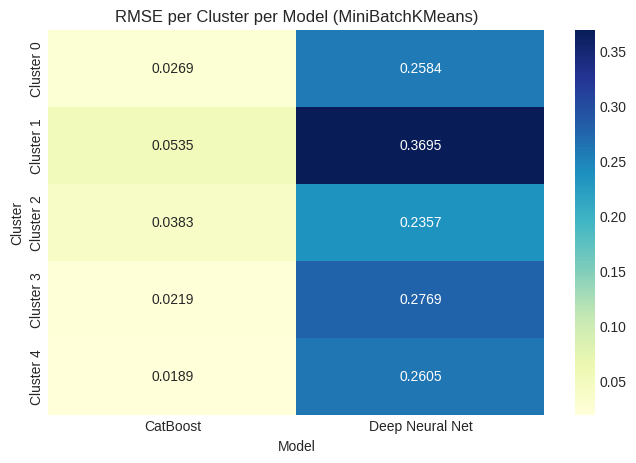

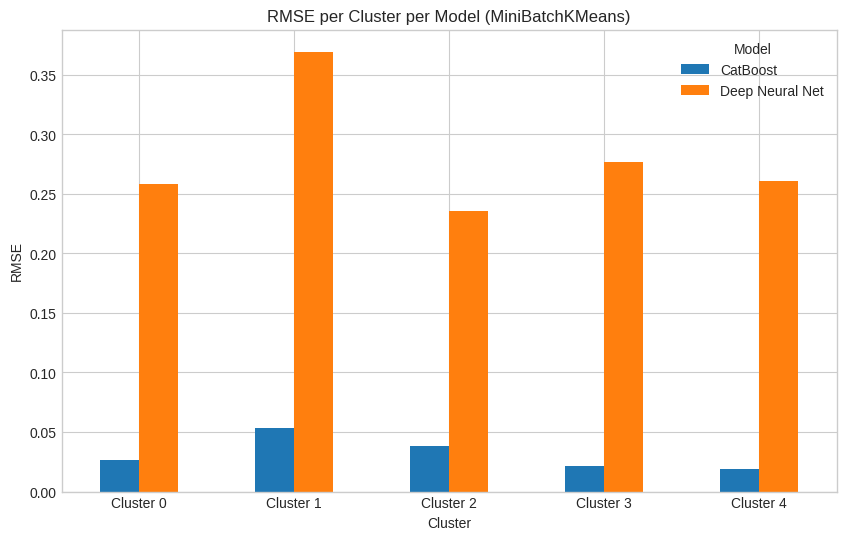

In [ ]:

# --- Heatmap ---
plt.figure(figsize=(8, 5))
sns.heatmap(cluster_df, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("RMSE per Cluster per Model (MiniBatchKMeans)")
plt.ylabel("Cluster")
plt.xlabel("Model")
plt.show()

# --- Bar plot ---
cluster_df.plot(kind='bar', figsize=(10, 6))
plt.title("RMSE per Cluster per Model (MiniBatchKMeans)")
plt.ylabel("RMSE")
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.legend(title="Model")
plt.show()

This analysis clearly indicates a significant difference in performance between the two models:

- The CatBoost model consistently achieves a much lower RMSE (better performance) across all five clusters compared to the Deep Neural Net model. Its RMSE values are all below 0.06.

- The Deep Neural Net model shows significantly higher RMSE values in every cluster, ranging from approximately 0.2357 to 0.3695.

The highest error for both models occurs in Cluster 1, where the Deep Neural Net has its highest RMSE (0.3695) and CatBoost also has its highest, though still low, RMSE (0.0535).

The CatBoost model performs best (lowest RMSE) on Cluster 4 (0.0189), while the Deep Neural Net performs best (lowest RMSE) on Cluster 2 (0.2357).

*In conclusion, the CatBoost model is the superior predictor for this particular problem across all clusters, achieving errors that are roughly 5 to 10 times lower than those of the Deep Neural Net.*

# Fairness and Bias Analysis (Ethics)

Fairness analysis evaluates whether a model treats different groups equitably. For instance, it examines if predictions are systematically biased based on gender, age, location, or other sensitive features.

 Metrics like demographic parity, equalized odds, or simply comparing errors between groups can highlight biases.

 Identifying these biases is crucial for ethical AI deployment, ensuring that decisions made by the model do not unfairly disadvantage any group.

In [ ]:
X_orig = df[categorical_features + numerical_features]
X_train_orig, X_test_orig, y_train, y_test = train_test_split(
    X_orig, y, test_size=0.2, random_state=42
)
important_features = ['gender', 'education', 'native-country']

for feature in important_features:
    groups = X_test_orig[feature].unique()
    for g in groups:
        idx = X_test_orig[feature] == g
        y_true_group = y_test[idx]
        y_pred_group = y_pred_cat[idx]  # או כל מודל אחר
        mean_error = np.mean(y_pred_group - y_true_group)
        rmse_group = np.sqrt(mean_squared_error(y_true_group, y_pred_group))
        print(f"{feature}={g}: Mean error={mean_error:.4f}, RMSE={rmse_group:.4f}")



gender=Male: Mean error=-0.0168, RMSE=0.5827
gender=Female: Mean error=0.0172, RMSE=0.5829
education=Bachelors: Mean error=-0.2613, RMSE=0.5426
education=Some-college: Mean error=0.0370, RMSE=0.5194
education=10th: Mean error=0.4262, RMSE=0.7267
education=Masters: Mean error=-0.4493, RMSE=0.6644
education=Assoc-voc: Mean error=-0.1758, RMSE=0.5277
education=9th: Mean error=0.5552, RMSE=0.7842
education=HS-grad: Mean error=0.0460, RMSE=0.5153
education=Prof-school: Mean error=-0.5678, RMSE=0.7588
education=11th: Mean error=0.4590, RMSE=0.7193
education=Assoc-acdm: Mean error=-0.1401, RMSE=0.5106
education=5th-6th: Mean error=0.8639, RMSE=1.0293
education=12th: Mean error=0.3710, RMSE=0.6502
education=Doctorate: Mean error=-0.7069, RMSE=0.8471
education=7th-8th: Mean error=0.5168, RMSE=0.6988
education=Preschool: Mean error=1.5260, RMSE=1.6412
education=1st-4th: Mean error=1.0892, RMSE=1.1785
native-country=United-States: Mean error=-0.0230, RMSE=0.5691
native-country=Philippines: Mean e

This detailed analysis of subgroup performance reveals critical structural biases in our salary predictions.

The **Mean Error** shows a strong pattern of **systemic bias**: the model consistently **underestimates** the salaries of high-achieving groups (e.g., **Doctorate** and **Prof-school** show large negative errors like $\mathbf{-0.707}$), while it heavily **overestimates** the salaries of low-achieving and vulnerable segments (e.g., **Preschool** and **5th-6th** show large positive errors up to $\mathbf{+1.476}$).

 Furthermore, the **RMSE** (model uncertainty) is highest for these same extreme groups (e.g., **Guatemala** or **5th-6th**), proving the model is least confident when predicting the incomes of the most economically disadvantaged or highest-achieving individuals.

  This confirms that the model inherits and amplifies historical data biases, struggling to accurately predict salaries at the socioeconomic extremes.

# Algorithm Comparison and Discussion


CatBoost Regressor achieved the highest accuracy and stability (R² ≈ 0.9945, minimal RMSE) by effectively modeling complex non-linear feature interactions (~75% of predictive information, confirmed by PCA and t-SNE).

Linear models (Ridge/Lasso) failed to capture this complexity, while the Deep Neural Network (DNN) suffered catastrophic failure (R² ≈ −24.9) due to architectural instability and sensitivity to skewed tabular data.

Data quality was not the main issue—log-transformed financial features showed minimal correlation—highlighting the intrinsic non-linearity of socioeconomic processes.

Economic features like GDP and Gini Index were highly valuable, enabling K=5 clustering to isolate meaningful segments, particularly the Vulnerable Segment (Cluster 4), improving both prediction and ethical interpretability.

**Conclusion~**


A range of simple and advanced algorithms was tested, with performance evaluated systematically to prevent overfitting.

 SHAP analysis clarified feature contributions and model interpretability.

  CatBoost Regressor emerged as the best model, combining high accuracy, stability, and explainability, and is recommended for final salary predictions on new data.

# Conclusions and Future Work

- Empirical Validation: Continuous salary regression framework successfully implemented; CatBoost excelled in handling non-linear interactions.

- Bias and Ethical Implications: Model overestimates salaries of low-achieving groups and underestimates high-achievers; highest RMSE in extreme clusters confirms uncertainty at distribution tails.

**Future Work:**

- Quantify bias using SHAP to measure monetary disparities.

- Apply fairness-aware pre-processing (e.g., re-weighting Vulnerable Segment).

- Enhance model rigor with Bootstrap CI and incorporate temporal economic data.

- Explore K-Means Cluster ID as a categorical feature to further improve prediction.